# Detection of Parkinson’s Disease from Speech and X-Vector Representations

In [1]:
# Import libraries
import os
import re
import sys
import time
import glob
import json
import torch
import shutil
import pickle
import pandas
import random
import pandas 
import librosa
import torchaudio
import numpy as np
import pandas as pd
import tensorflow as keras
import matplotlib.pyplot as plt

from pathlib import Path
from addict import Dict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Speechbrain
from speechbrain.inference.classifiers import EncoderClassifier
from speechbrain.inference import EncoderClassifier
from speechbrain.utils.checkpoints import Checkpointer
from hyperpyyaml import load_hyperpyyaml


sys.path.append("/home/duyenkl/speechbrain/templates/speaker_id/")


2025-01-21 12:49:59.863977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 12:50:00.297432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 12:50:00.457257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 12:50:01.361554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 12:50:07.140570: W tensorflow/compiler/tf2

# Define location of source data and the target root directory

Specifies source root directory of PC-GITA dataset, and points to the subdirectory of 16kHZ of PC-GITA dataset, and then specifies a new root directory to store and copy data and models.

In [2]:
# Specify source root directory (for 16kHz version of PC-GITA)
gita_dir = '/home/duyenkl/Speech/PC-GITA-v2'

# Specify subdirectory within the source root (with 16kHz version of PC-GITA)
source_dir = os.path.join(gita_dir, 'PC-GITA_per_task_16000Hz')

# Specify new target root location
trgt_root = '/home/duyenkl/Parkinson2/' 

# Create paths for csv file, model directory and metadata in target root directory
thecsv = os.path.join(trgt_root, 'wav.csv')
model_root = os.path.join(trgt_root, 'Models')
os.makedirs(model_root, exist_ok=True)

verbose_feat = False

In [3]:
# Check existence of directories
print('gita_dir:' + gita_dir)
print('source_dir: ' + source_dir)
print('trgt_root:' + trgt_root)
print('\n')

# Check content of source_dir
print('Content of source_dir: ')
print(os.listdir(source_dir))

gita_dir:/home/duyenkl/Speech/PC-GITA-v2
source_dir: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz
trgt_root:/home/duyenkl/Parkinson2/


Content of source_dir: 
['DDK_analysis', 'Vowels', 'Words', 'modulated_vowels', 'monologue', 'read_text', 'sentences', 'sentences2', '.DS_Store', 'noise']


# Create target directory structure

Goes through all directories in source root directories and creates corresponding directories in target root location.

In [4]:
# For each found directory, create a corresponding directory structure in a target root directory (mirrors source_dir into trgt_root)
for dirs in [x[0] for x in os.walk(source_dir)]:
    dir_path = os.path.relpath(dirs, source_dir)
    trgt_dir = os.path.join(trgt_root, dir_path)
    print(trgt_dir)
    try:
        os.makedirs(trgt_dir,exist_ok=True)
    except Exception as e:
        print('Error creating directory' + trgt_dir + e)

/home/duyenkl/Parkinson2/.
/home/duyenkl/Parkinson2/DDK_analysis
/home/duyenkl/Parkinson2/DDK_analysis/ka-ka-ka
/home/duyenkl/Parkinson2/DDK_analysis/ka-ka-ka/sin_normalizar
/home/duyenkl/Parkinson2/DDK_analysis/ka-ka-ka/sin_normalizar/hc
/home/duyenkl/Parkinson2/DDK_analysis/ka-ka-ka/sin_normalizar/pd
/home/duyenkl/Parkinson2/DDK_analysis/pa-pa-pa
/home/duyenkl/Parkinson2/DDK_analysis/pa-pa-pa/sin_normalizar
/home/duyenkl/Parkinson2/DDK_analysis/pa-pa-pa/sin_normalizar/hc
/home/duyenkl/Parkinson2/DDK_analysis/pa-pa-pa/sin_normalizar/pd
/home/duyenkl/Parkinson2/DDK_analysis/pakata
/home/duyenkl/Parkinson2/DDK_analysis/pakata/sin_normalizar
/home/duyenkl/Parkinson2/DDK_analysis/pakata/sin_normalizar/hc
/home/duyenkl/Parkinson2/DDK_analysis/pakata/sin_normalizar/pd
/home/duyenkl/Parkinson2/DDK_analysis/pataka
/home/duyenkl/Parkinson2/DDK_analysis/pataka/sin_normalizar
/home/duyenkl/Parkinson2/DDK_analysis/pataka/sin_normalizar/HC
/home/duyenkl/Parkinson2/DDK_analysis/pataka/sin_normaliza

# Collect filepaths of all waveforms according to specific cathegory

In [5]:
# glob used to retrieve file paths for different categories
def get_files(path, extension, recursive=False):
    """
    A generator of filepaths for each file into path with the target extension.
    If recursive, it will loop over subfolders as well.
    """
    if not recursive:
        for file_path in glob.glob(path + "/*." + extension):
            yield file_path
    else:
        for root, dirs, files in os.walk(path):
            for file_path in glob.glob(root + "/*." + extension):
                yield file_path
                
# Get file paths for DDK analysis category
ddk = list(get_files(os.path.join(source_dir,'DDK_analysis'),'wav',recursive=True))

# Get file paths for Vowels category
vowels = list(get_files(os.path.join(source_dir,'Vowels'),'wav',recursive=True))
modulated_vowels = list(get_files(os.path.join(source_dir,'modulated_vowels'),'wav',recursive=True))

# Get file paths for Words category
words = list(get_files(os.path.join(source_dir,'Words'),'wav',recursive=True))

# Get file paths for Sentences category
sentences = list(get_files(os.path.join(source_dir,'sentences'),'wav',recursive=True))
sentences2 = list(get_files(os.path.join(source_dir,'sentences2'),'wav',recursive=True))


# Get file paths for Read Text category
read_text = list(get_files(os.path.join(source_dir,'read_text'),'wav',recursive=True))

# Get file paths for Monologues category
monologues = list(get_files(os.path.join(source_dir,'monologue'),'wav',recursive=True))

In [6]:
print(ddk)
print(vowels)
print(modulated_vowels)
print(words)
print(sentences)
print(sentences2)
print(read_text)
print(monologues)

['/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0001_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0003_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0004_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0005_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0006_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0007_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0008_ka.wav', '/home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0010_ka.wav', '/home/duyenkl/Speech/P

In [7]:
print(len(ddk))
print(len(vowels))
print(len(modulated_vowels))
print(len(words))
print(len(sentences))
print(len(sentences2))
print(len(read_text))
print(len(monologues))

600
1500
500
2499
697
400
117
100


# Look into meta data about patients and some statistical parameters

About the columns
* RECODING ORIGINAL NAME: file name of recording
* UPDRS: Parkinson’s disease rating scale
* UPDRS-speech Parkinson’s disease rating scale related to speech
* H/Y: Hoehn&Yahr scale, Parkinson's disease rating scale

In [9]:
# Look into meta data about patients
metadata_path = '/home/duyenkl/duyenkl_aulus3/Parkinson/PC-GITA-v2/PCGITA_metadata.xlsx'
metadata = pandas.read_excel(metadata_path)

idfull = list(metadata['RECODING ORIGINAL NAME'])
for id in range(len(idfull)):
    idfull[id]=idfull[id].replace('AVPEPUDE', '')
metadata.insert(0, 'ID', idfull, True)
metadata.head(100)

,ID,RECODING ORIGINAL NAME,UPDRS,UPDRS-speech,H/Y,SEX,AGE,time after diagnosis
0,A0001,AVPEPUDEA0001,28.0,1.0,2.0,M,64,3.0
1,A0002,AVPEPUDEA0002,19.0,0.0,1.0,F,72,2.5
2,A0003,AVPEPUDEA0003,52.0,2.0,3.0,F,75,3.0
3,A0005,AVPEPUDEA0005,32.0,1.0,2.0,M,65,12.0
4,A0006,AVPEPUDEA0006,28.0,1.0,2.0,F,66,4.0
...,...,...,...,...,...,...,...,...
95,AC0051,AVPEPUDEAC0051,NaN,NaN,NaN,M,31,NaN
96,AC0052,AVPEPUDEAC0052,NaN,NaN,NaN,M,42,NaN
97,AC0053,AVPEPUDEAC0053,NaN,NaN,NaN,F,50,NaN
98,AC0054,AVPEPUDEAC0054,NaN,NaN,NaN,F,49,NaN


In [10]:
# Get some statistical data
print('Entries total: ' + str(len(metadata)))
print('Average age: ' + str(metadata['AGE'].mean()) + '\n')

print(metadata['SEX'].value_counts())
print('\n')

print('Age average by sex\n')
print(metadata.groupby('SEX')['AGE'].mean())

Entries total: 100
Average age: 61.0

SEX
M    50
F    50
Name: count, dtype: int64


Age average by sex

SEX
F    61.08
M    60.92
Name: AGE, dtype: float64


# System with Pre-Trained X-Vector Model 

###  Generating x-vectors embeddings for the dataset (with speaking tasks DDK, read text, monologues and sentences) using a pre-trained x-vector model

In [11]:
# Obtain the pre-trained x-vector model 
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="tmp/xvect_model")

# Function to read audio files
def process_audio_file(file_path, classifier):
    try:
        signal, sample_rate = torchaudio.load(file_path)
        
        # Resample if necessary (pretrained x-vector model assumes 16kHz wav files)
        if sample_rate != 16000:
            transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            signal = transform(signal)
            
        # Extract 512-dim x-vector for the utterance  
        x_vector = classifier.encode_batch(signal)
        return x_vector.squeeze(0).cpu().numpy() # Convert to numpy array
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None
    
# Creating a directory that combines all audio files 
speaking_task_filepaths = {
    "DDK": ddk,
    "Sentences": sentences,
    "Monologue": monologues,
    "Read text": read_text,
    "Sentences2": sentences2,
}

xvector_dir = "/home/duyenkl/Parkinson2/x_vectors"
os.makedirs(xvector_dir, exist_ok=True)

# Process each audio file and store the x-vectors
x_vectors = {}
for task, file_paths in speaking_task_filepaths.items():
    task_vectors = []
    
    for file_path in file_paths:
        print(f"Processing audio file: {file_path}")
        x_vector = process_audio_file(file_path, classifier)
        if x_vector is not None:
            task_vectors.append((file_path, x_vector))
    
    # Save x-vectors and audio file paths for each speaking task in the dataset
    if task_vectors:
        file_paths_list = [entry[0] for entry in task_vectors] 
        x_vector_array = np.array([entry[1] for entry in task_vectors])
        
        output_file_xvectors = os.path.join(xvector_dir, f"{task}_x_vectors.npy")
        output_file_filepaths = os.path.join(xvector_dir, f"{task}_filepaths.npy")
        
        np.save(output_file_xvectors, x_vector_array)  
        np.save(output_file_filepaths, file_paths_list)  

print("Completed x-vector extraction for specific speaking tasks.")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
/home/duyenkl/GitHub/speechbrain/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fet

Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0001_ka.wav
Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0003_ka.wav
Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0004_ka.wav
Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0005_ka.wav
Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0006_ka.wav
Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0007_ka.wav
Processing audio file: /home/duyenkl/Speech/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0008_ka.wav
Proces

### Training and testing a simple SVM classifier on data (with speaking tasks DDK, read text, monologues and sentences) with x-vectors from pre-trained model

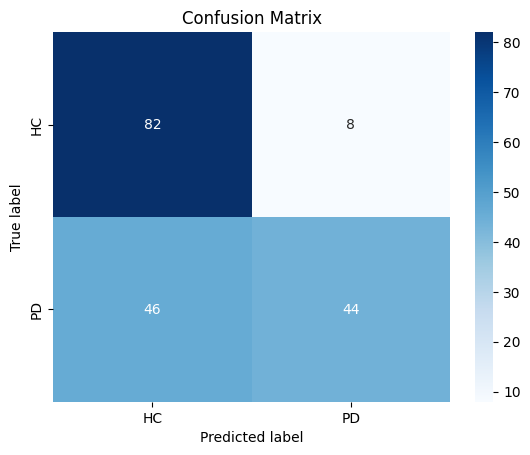

Accuracy for fold 1: 0.7000
Sensitivity for fold 1: 0.4889
Specificity for fold 1: 0.9111
Precision for fold 1: 0.8462
Recall for fold 1: 0.4889
F1 Score for fold 1: 0.6197
ROC AUC for fold 1: 0.6457


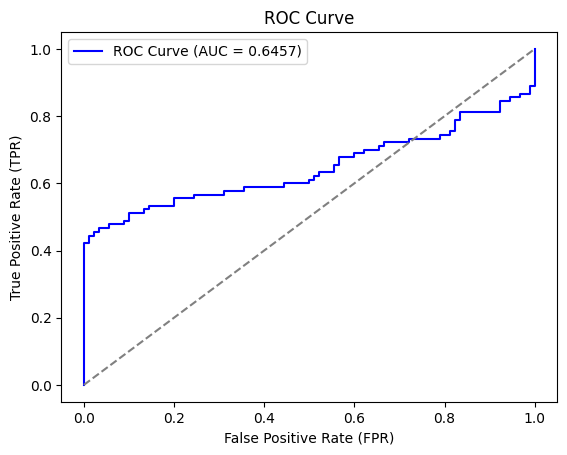

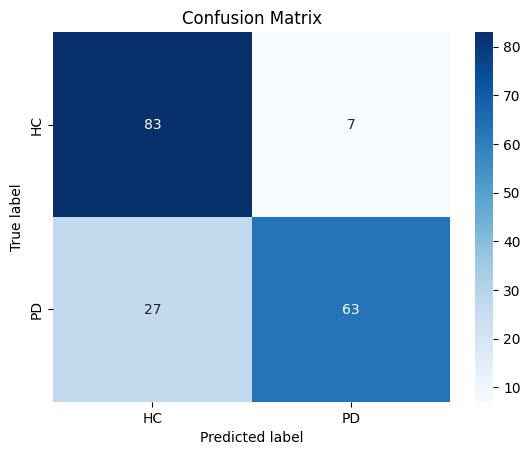

Accuracy for fold 2: 0.8111
Sensitivity for fold 2: 0.7000
Specificity for fold 2: 0.9222
Precision for fold 2: 0.9000
Recall for fold 2: 0.7000
F1 Score for fold 2: 0.7875
ROC AUC for fold 2: 0.8889


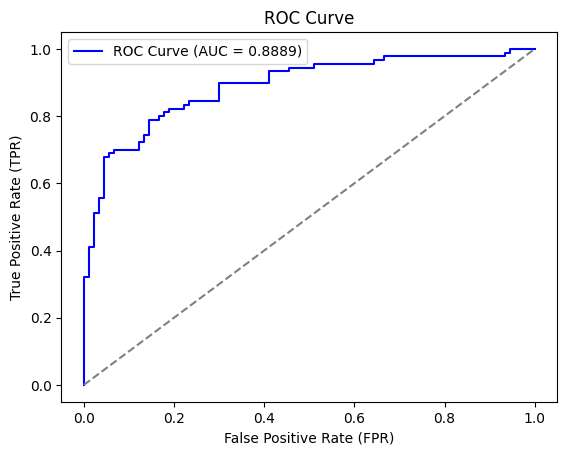

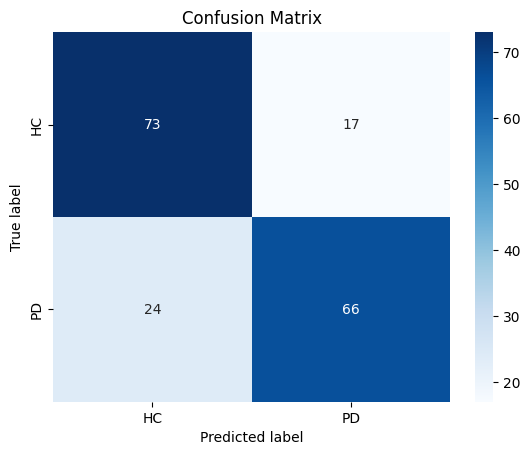

Accuracy for fold 3: 0.7722
Sensitivity for fold 3: 0.7333
Specificity for fold 3: 0.8111
Precision for fold 3: 0.7952
Recall for fold 3: 0.7333
F1 Score for fold 3: 0.7630
ROC AUC for fold 3: 0.8677


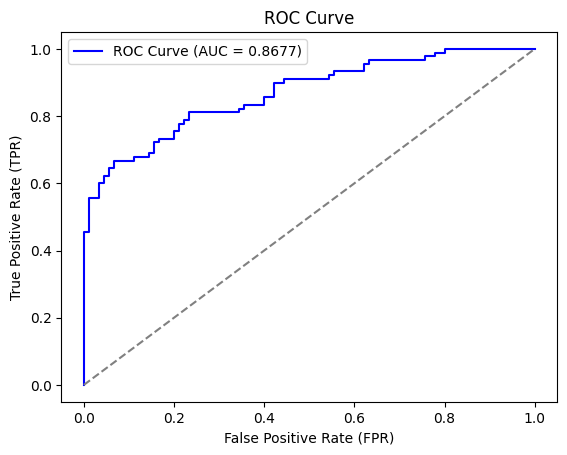

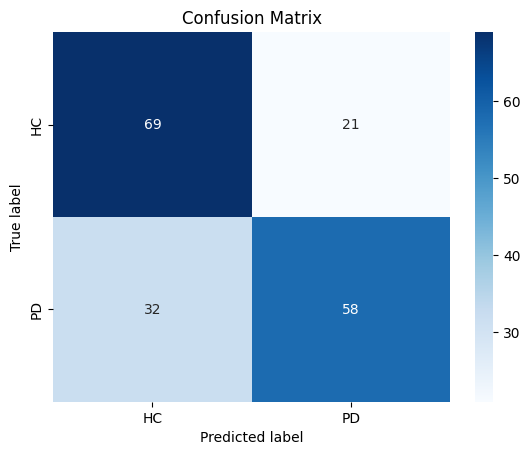

Accuracy for fold 4: 0.7056
Sensitivity for fold 4: 0.6444
Specificity for fold 4: 0.7667
Precision for fold 4: 0.7342
Recall for fold 4: 0.6444
F1 Score for fold 4: 0.6864
ROC AUC for fold 4: 0.7969


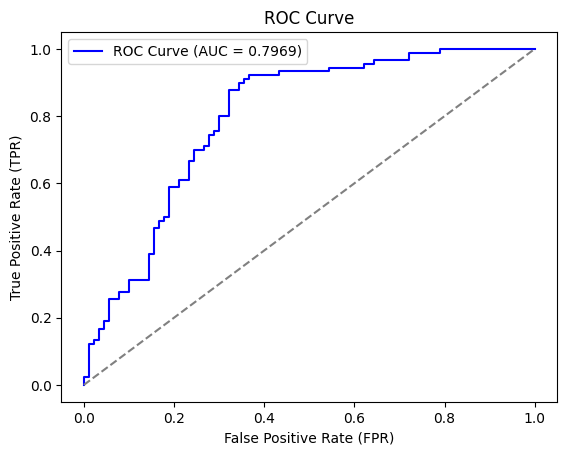

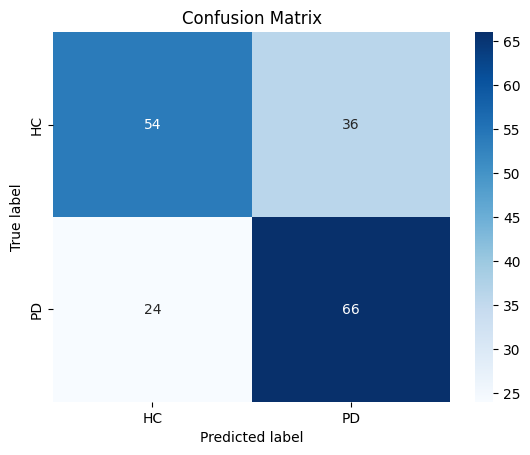

Accuracy for fold 5: 0.6667
Sensitivity for fold 5: 0.7333
Specificity for fold 5: 0.6000
Precision for fold 5: 0.6471
Recall for fold 5: 0.7333
F1 Score for fold 5: 0.6875
ROC AUC for fold 5: 0.7228


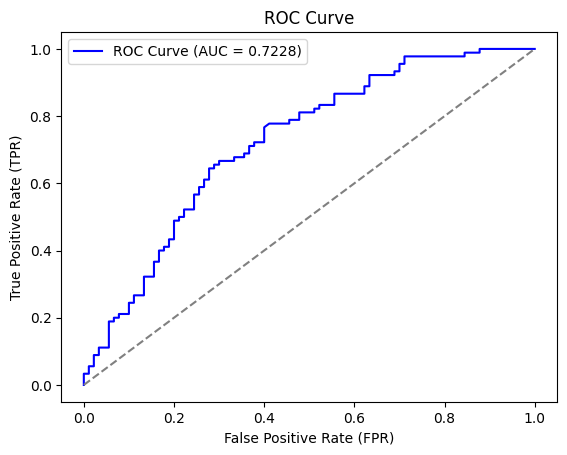

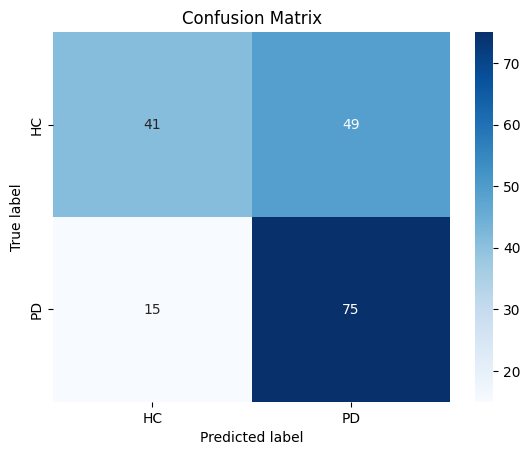

Accuracy for fold 6: 0.6444
Sensitivity for fold 6: 0.8333
Specificity for fold 6: 0.4556
Precision for fold 6: 0.6048
Recall for fold 6: 0.8333
F1 Score for fold 6: 0.7009
ROC AUC for fold 6: 0.7605


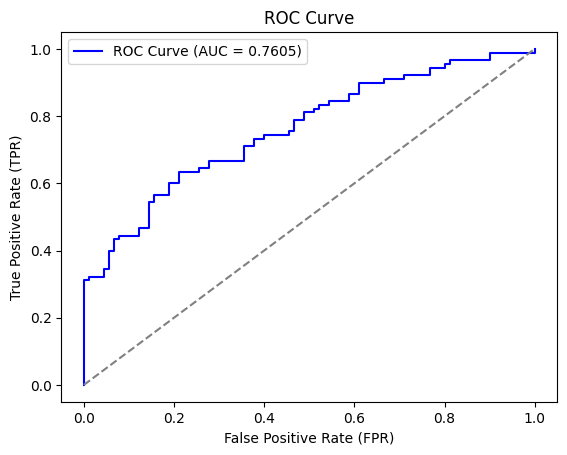

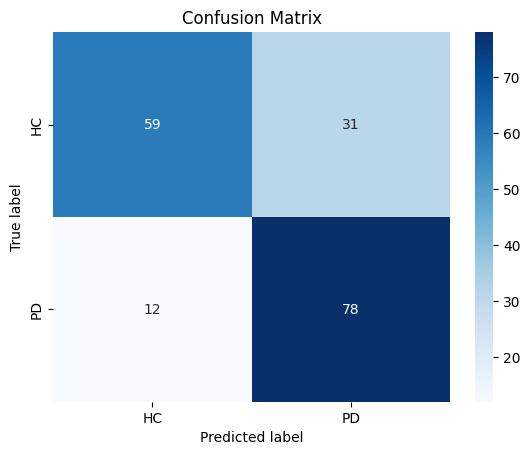

Accuracy for fold 7: 0.7611
Sensitivity for fold 7: 0.8667
Specificity for fold 7: 0.6556
Precision for fold 7: 0.7156
Recall for fold 7: 0.8667
F1 Score for fold 7: 0.7839
ROC AUC for fold 7: 0.8469


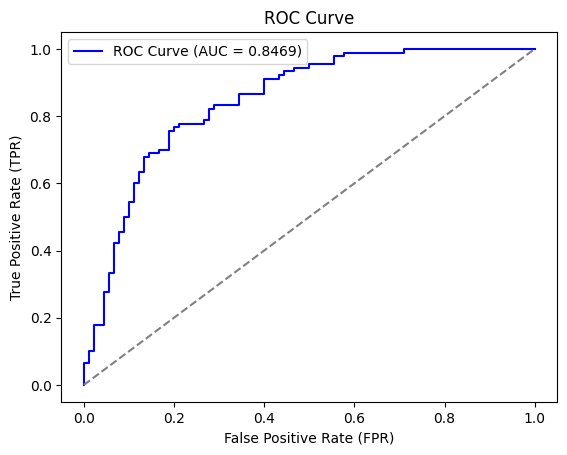

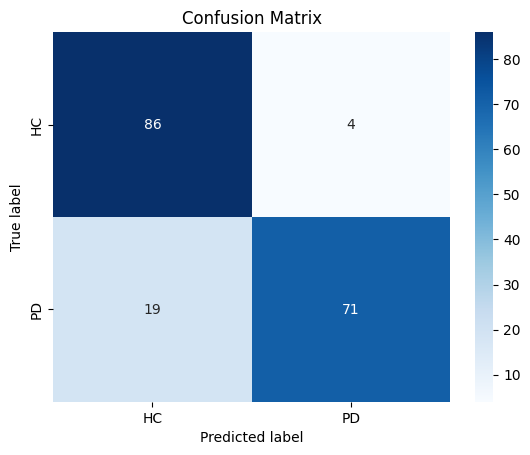

Accuracy for fold 8: 0.8722
Sensitivity for fold 8: 0.7889
Specificity for fold 8: 0.9556
Precision for fold 8: 0.9467
Recall for fold 8: 0.7889
F1 Score for fold 8: 0.8606
ROC AUC for fold 8: 0.9233


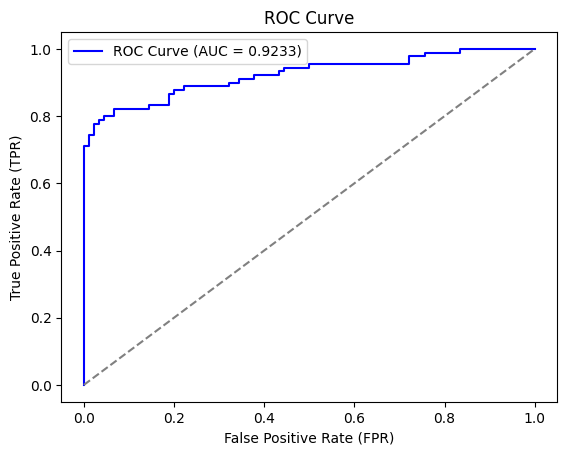

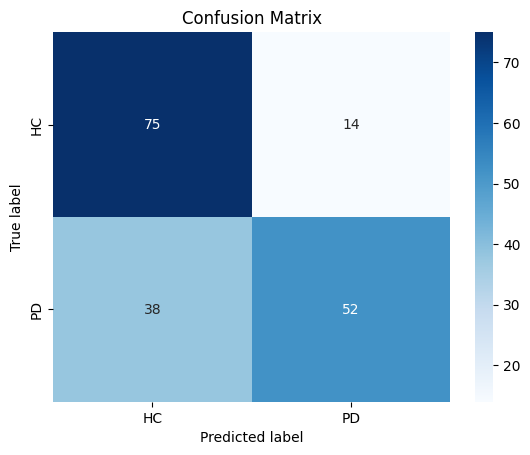

Accuracy for fold 9: 0.7095
Sensitivity for fold 9: 0.5778
Specificity for fold 9: 0.8427
Precision for fold 9: 0.7879
Recall for fold 9: 0.5778
F1 Score for fold 9: 0.6667
ROC AUC for fold 9: 0.7541


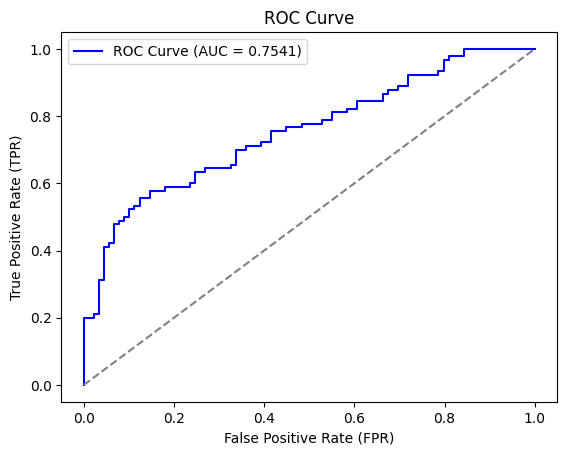

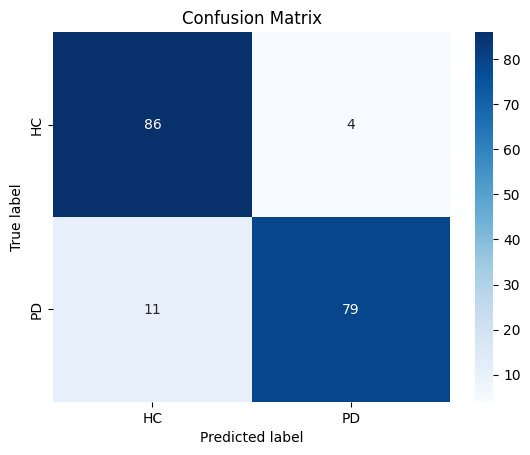

Accuracy for fold 10: 0.9167
Sensitivity for fold 10: 0.8778
Specificity for fold 10: 0.9556
Precision for fold 10: 0.9518
Recall for fold 10: 0.8778
F1 Score for fold 10: 0.9133
ROC AUC for fold 10: 0.9895


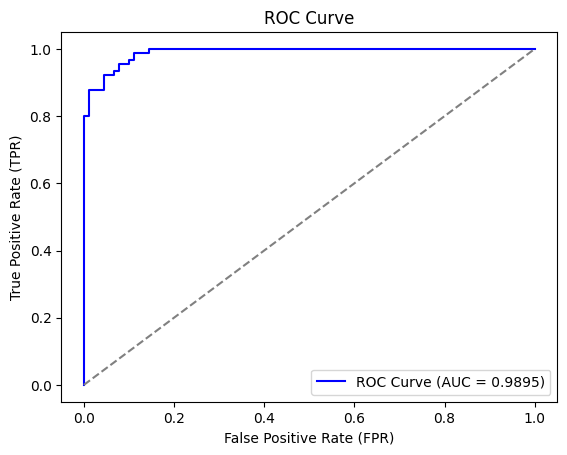

Average of evaluation metrics across folds:
Average accuracy: 0.7559 ± 0.0842
Average sensitivity: 0.7244 ± 0.1200
Average specificity: 0.7876 ± 0.1602
Average precision: 0.7929 ± 0.1137
Average recall: 0.7244 ± 0.1200
Average f1_score: 0.7470 ± 0.0871
Average roc_auc: 0.8196 ± 0.0977


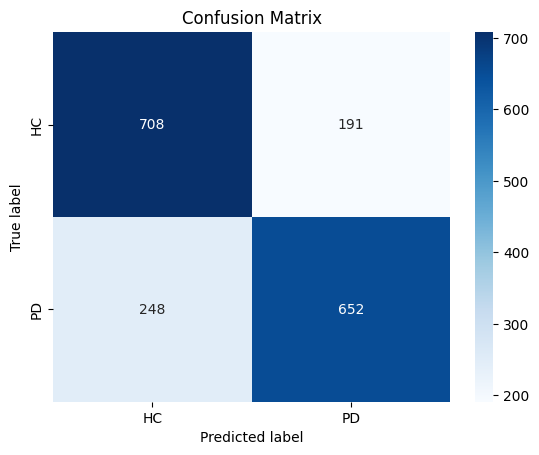

In [15]:
# Define paths for folds and xvectors
folds_dir = '/home/duyenkl/SSL4PR/pcgita_splits'
x_vectors_dir = '/home/duyenkl/Parkinson2/x_vectors'
x_vector_dict = {}

# Load x-vectors and audio file paths for all tasks
def load_x_vectors(task):
    x_vectors = np.load(os.path.join(x_vectors_dir, f"{task}_x_vectors.npy"))
    file_paths = np.load(os.path.join(x_vectors_dir, f"{task}_filepaths.npy"), allow_pickle=True)
    return dict(zip(file_paths, x_vectors))

# Combine x-vectors for all speaking tasks
def combine_x_vectors(tasks):
    combined_vectors = {}
    for task in tasks:
        task_vectors = load_x_vectors(task)
        combined_vectors.update(task_vectors)
    return combined_vectors

# Load x-vectors for all speaking tasks
#tasks = ["DDK", "Vowels", "Words", "Sentences", "Monologue", "Read text", "Sentences2", "Modulated Vowels"]
tasks = ["DDK", "Sentences", "Monologue", "Read text", "Sentences2"]

x_vector_dict = combine_x_vectors(tasks)


# Prepare data for a fold
def prepare_data(csv_path, x_vector_dict):
    data = pandas.read_csv(csv_path)
    
    # Map audio path to x-vectors
    data['x_vector'] = data['audio_path'].map(x_vector_dict)
    data = data.dropna(subset={'x_vector'}) # Remove rows without x-vectors
    
    # Extract x-vectors and labels
    X = np.vstack(data['x_vector'].values)  # Stack x-vectors into a 2D-array
    y = (data['status'] == 'pd').astype(int).values # Convert 'pd' to 1 and 'hc' to 0
    
    return X, y

results = []
total_cm = np.zeros((2, 2), dtype=int)

# Iterate through all folds in dataset
for fold_idx in range(1,11): 

    # Define path for current fold
    fold_dir = os.path.join(folds_dir, f"TRAIN_TEST_{fold_idx}") 
    
    # File paths for sets in current fold
    train_csv = os.path.join(fold_dir, "train.csv")
    test_csv = os.path.join(fold_dir, "test.csv")
    valid_csv = os.path.join(fold_dir, "valid.csv")
    
    # Prepare train and test data
    X_train, y_train = prepare_data(train_csv, x_vector_dict)
    X_test, y_test = prepare_data(test_csv, x_vector_dict)
    X_valid, y_valid = prepare_data(valid_csv, x_vector_dict)

    # Train SVM classifier for current fold 
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)

    # Evaluate SVM classifier
    y_pred = clf.predict(X_test)
    
    # Evalution metrics
    cm = confusion_matrix(y_test, y_pred)
    total_cm += cm
    plt.figure()
    labels = ['HC', 'PD']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for fold {fold_idx}: {accuracy:.4f}')
    
    sensitivity = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    print(f'Sensitivity for fold {fold_idx}: {sensitivity:.4f}')
    print(f'Specificity for fold {fold_idx}: {specificity:.4f}')   
     
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Precision for fold {fold_idx}: {precision:.4f}')
    print(f'Recall for fold {fold_idx}: {recall:.4f}')
    print(f'F1 Score for fold {fold_idx}: {f1:.4f}')
    
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f'ROC AUC for fold {fold_idx}: {roc_auc:.4f}')
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    
    # Save the results for the current fold
    results.append({
        'fold': fold_idx,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    })
    
    results_df = pandas.DataFrame(results)
    results_csv = '/home/duyenkl/Parkinson2/evaluation_metrics/pretrained_xvector_svm.csv'
    results_df.to_csv(results_csv, index=False)
    
# Average of evaluation metrics across folds with standard deviation
print(f'Average of evaluation metrics across folds:')
for metric in ['accuracy', 'sensitivity', 'specificity', 'precision', 'recall', 'f1_score', 'roc_auc']:
    metric_value = results_df[metric]
    average = np.mean(metric_value)
    standard_deviation = np.std(metric_value)
    print(f'Average {metric}: {average:.4f} ± {standard_deviation:.4f}')
        
plt.figure()
labels = ['HC', 'PD']
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


### Training and testing a simple CNN classifier on data (with speaking tasks DDK, read text, monologues and sentences) with x-vectors from pre-trained model

/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737462199.471667 3258035 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737462199.474523 3258035 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-21 13:23:19.5877

Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6257 - loss: 0.8867 - val_accuracy: 0.4753 - val_loss: 1.4095
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8120 - loss: 0.4913 - val_accuracy: 0.6605 - val_loss: 0.6208
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8442 - loss: 0.4486 - val_accuracy: 0.7963 - val_loss: 0.3603
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8485 - loss: 0.3914 - val_accuracy: 0.8951 - val_loss: 0.2996
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8695 - loss: 0.3560 - val_accuracy: 0.9321 - val_loss: 0.2221
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8867 - loss: 0.3364 - val_accuracy: 0.9198 - val_loss: 0.2212
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8925 - loss: 0.3041 - val_accuracy: 0.9321 - val_loss: 0.1745
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8946 - loss: 0.2704 - val_accuracy: 0.9444 - v

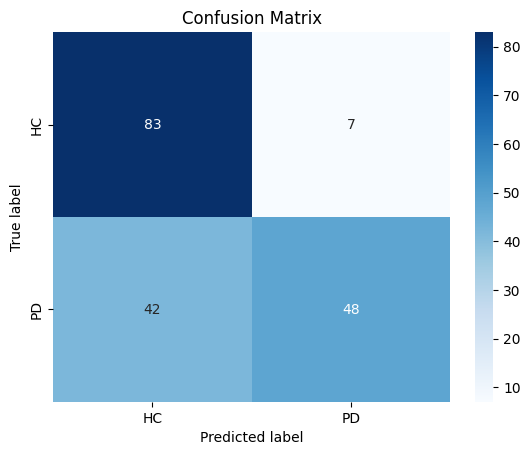

Accuracy for fold 1: 0.7278
Sensitivity for fold 1: 0.5333
Specificity for fold 1: 0.9222
Precision for fold 1: 0.8727
Recall for fold 1: 0.5333
F1 Score for fold 1: 0.6621
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 1: 0.7112
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


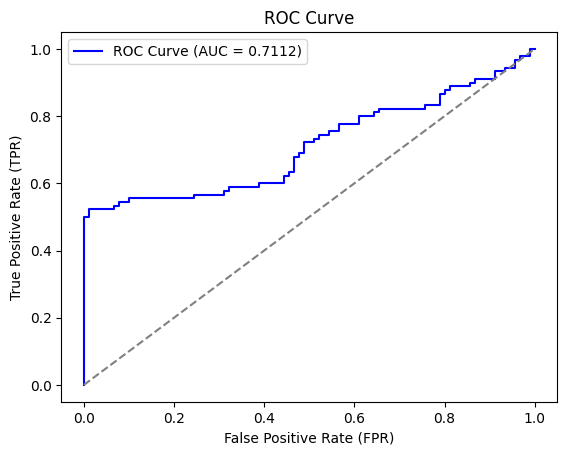

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6009 - loss: 0.8457 - val_accuracy: 0.7222 - val_loss: 0.5089
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8006 - loss: 0.5008 - val_accuracy: 0.6667 - val_loss: 0.6275
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8254 - loss: 0.4262 - val_accuracy: 0.7901 - val_loss: 0.3873
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8449 - loss: 0.3812 - val_accuracy: 0.9074 - val_loss: 0.2588
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8578 - loss: 0.3911 - val_accuracy: 0.9630 - val_loss: 0.1867
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8702 - loss: 0.3281 - val_accuracy: 0.9568 - val_loss: 0.1725
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8964 - loss: 0.3043 - val_accuracy: 0.9198 - val_loss: 0.2301
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8826 - loss: 0.3191 - val_accuracy: 0.9383 - val_loss: 0.

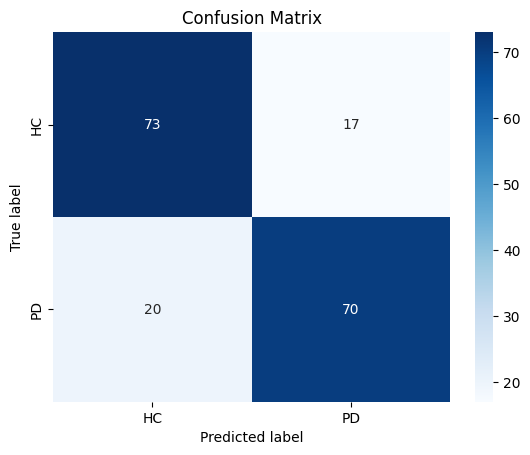

Accuracy for fold 2: 0.7944
Sensitivity for fold 2: 0.7778
Specificity for fold 2: 0.8111
Precision for fold 2: 0.8046
Recall for fold 2: 0.7778
F1 Score for fold 2: 0.7910
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 2: 0.8638
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


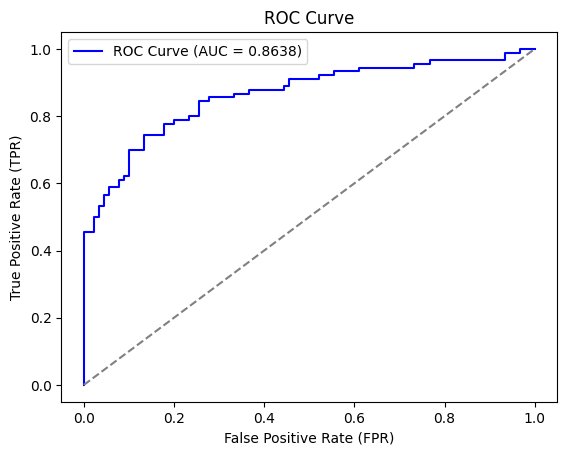

/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6246 - loss: 0.8619 - val_accuracy: 0.5123 - val_loss: 1.1083
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7600 - loss: 0.5633 - val_accuracy: 0.7654 - val_loss: 0.6040
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8250 - loss: 0.4627 - val_accuracy: 0.7469 - val_loss: 0.5700
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8579 - loss: 0.4024 - val_accuracy: 0.8642 - val_loss: 0.3165
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8658 - loss: 0.3678 - val_accuracy: 0.8704 - val_loss: 0.2837
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8730 - loss: 0.3570 - val_accuracy: 0.8457 - val_loss: 0.2796
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8666 - loss: 0.3357 - val_accuracy: 0.8704 - val_loss: 0.2678
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8771 - loss: 0.3178 - val_accuracy: 0.9074 - v

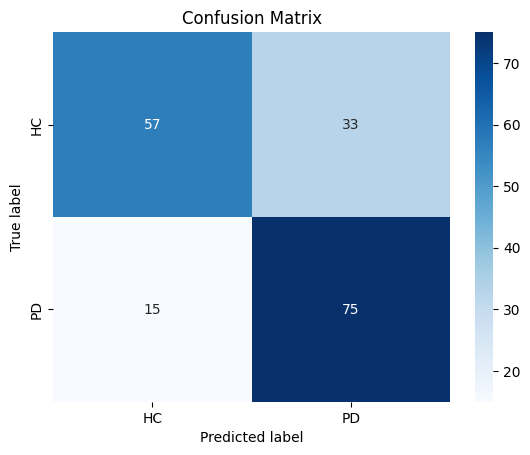

Accuracy for fold 3: 0.7333
Sensitivity for fold 3: 0.8333
Specificity for fold 3: 0.6333
Precision for fold 3: 0.6944
Recall for fold 3: 0.8333
F1 Score for fold 3: 0.7576
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 3: 0.8588
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


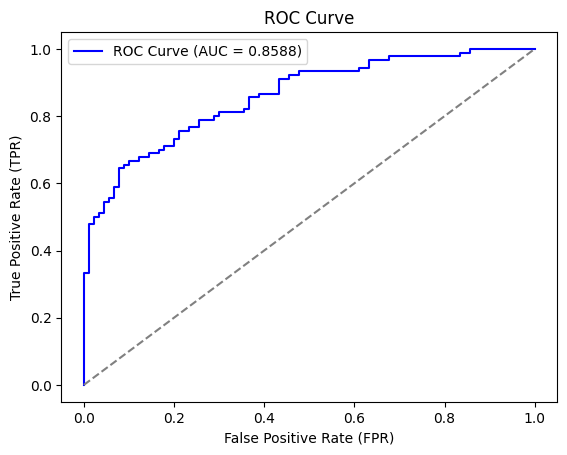

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5891 - loss: 0.8550 - val_accuracy: 0.3704 - val_loss: 1.6598
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7913 - loss: 0.4932 - val_accuracy: 0.5432 - val_loss: 0.8651
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8143 - loss: 0.4444 - val_accuracy: 0.8025 - val_loss: 0.3964
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8396 - loss: 0.4185 - val_accuracy: 0.9506 - val_loss: 0.2038
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8868 - loss: 0.3206 - val_accuracy: 0.9136 - val_loss: 0.2411
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8633 - loss: 0.3496 - val_accuracy: 0.9321 - val_loss: 0.2122
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8648 - loss: 0.3597 - val_accuracy: 0.9568 - val_loss: 0.1464
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8812 - loss: 0.3004 - val_accuracy: 0.9815 - val_loss: 0.

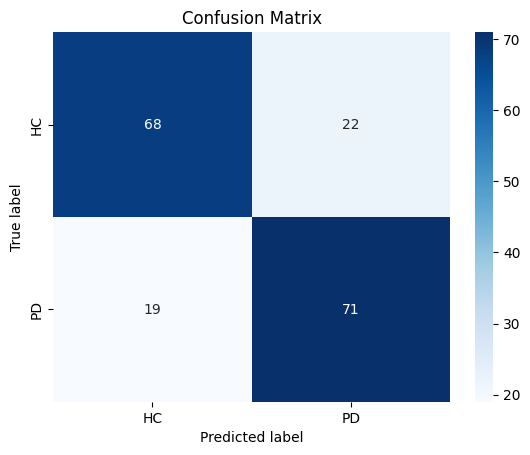

Accuracy for fold 4: 0.7722
Sensitivity for fold 4: 0.7889
Specificity for fold 4: 0.7556
Precision for fold 4: 0.7634
Recall for fold 4: 0.7889
F1 Score for fold 4: 0.7760
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 4: 0.8381
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


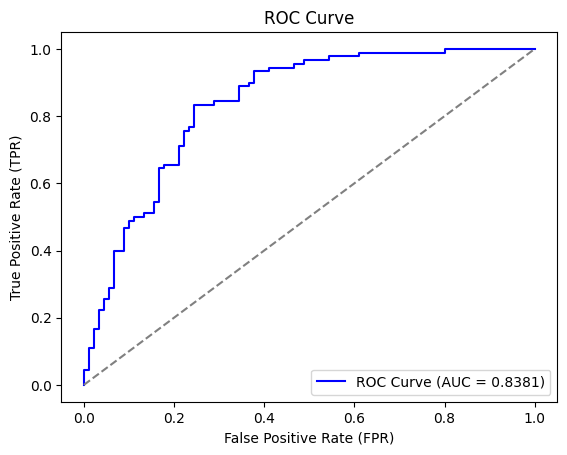

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6356 - loss: 0.8179 - val_accuracy: 0.7037 - val_loss: 0.5858
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7979 - loss: 0.4852 - val_accuracy: 0.8395 - val_loss: 0.3570
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8420 - loss: 0.3910 - val_accuracy: 0.8889 - val_loss: 0.2849
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8688 - loss: 0.3670 - val_accuracy: 0.9259 - val_loss: 0.1870
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8600 - loss: 0.3374 - val_accuracy: 0.9506 - val_loss: 0.1975
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9019 - loss: 0.2829 - val_accuracy: 0.9568 - val_loss: 0.1261
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8879 - loss: 0.2795 - val_accuracy: 0.9630 - val_loss: 0.1353
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9083 - loss: 0.2584 - val_accuracy: 0.9506 - val_loss: 0.

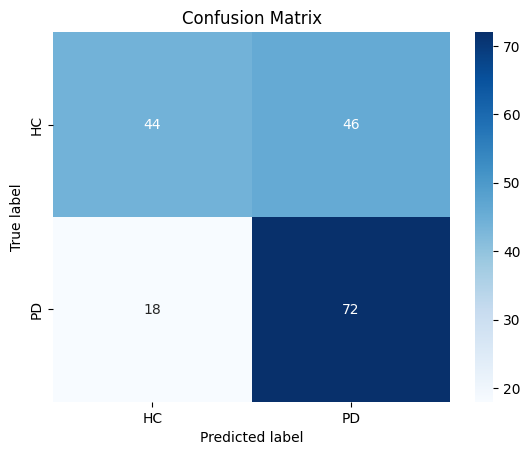

Accuracy for fold 5: 0.6444
Sensitivity for fold 5: 0.8000
Specificity for fold 5: 0.4889
Precision for fold 5: 0.6102
Recall for fold 5: 0.8000
F1 Score for fold 5: 0.6923
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ROC AUC for fold 5: 0.7119
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


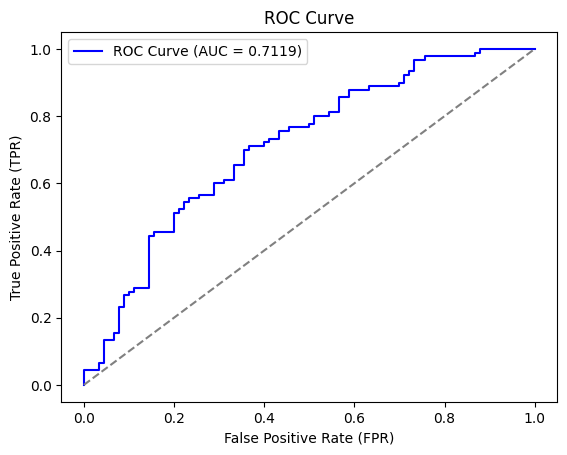

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6422 - loss: 0.7980 - val_accuracy: 0.5556 - val_loss: 0.9219
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7909 - loss: 0.4952 - val_accuracy: 0.6975 - val_loss: 0.5590
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8331 - loss: 0.4200 - val_accuracy: 0.8827 - val_loss: 0.3323
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8682 - loss: 0.3559 - val_accuracy: 0.8827 - val_loss: 0.3187
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8837 - loss: 0.3472 - val_accuracy: 0.8827 - val_loss: 0.3269
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8839 - loss: 0.3097 - val_accuracy: 0.8951 - val_loss: 0.2980
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8987 - loss: 0.3019 - val_accuracy: 0.8951 - val_loss: 0.3040
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8961 - loss: 0.2689 - val_accuracy: 0.8951 - val_loss: 0.

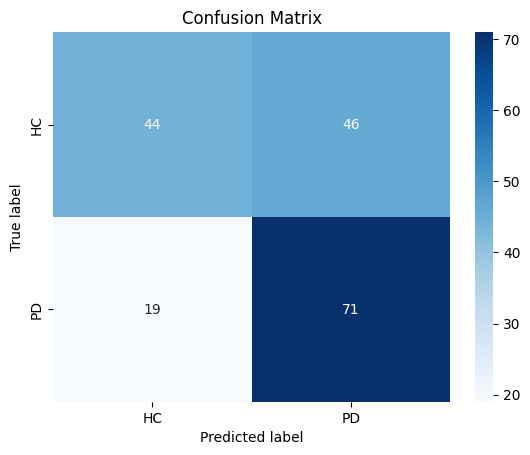

Accuracy for fold 6: 0.6389
Sensitivity for fold 6: 0.7889
Specificity for fold 6: 0.4889
Precision for fold 6: 0.6068
Recall for fold 6: 0.7889
F1 Score for fold 6: 0.6860
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 6: 0.7440
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


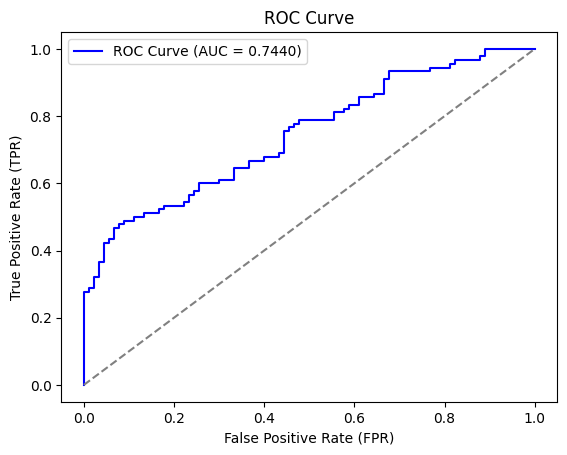

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6209 - loss: 0.8366 - val_accuracy: 0.3704 - val_loss: 1.6099
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7818 - loss: 0.5277 - val_accuracy: 0.6173 - val_loss: 0.6310
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8439 - loss: 0.4555 - val_accuracy: 0.8457 - val_loss: 0.3962
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8511 - loss: 0.4074 - val_accuracy: 0.9198 - val_loss: 0.2365
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8801 - loss: 0.3448 - val_accuracy: 0.9630 - val_loss: 0.1820
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8735 - loss: 0.3353 - val_accuracy: 0.9198 - val_loss: 0.2035
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8730 - loss: 0.3303 - val_accuracy: 0.9815 - val_loss: 0.1621
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8858 - loss: 0.2998 - val_accuracy: 0.9259 - val_loss: 0.

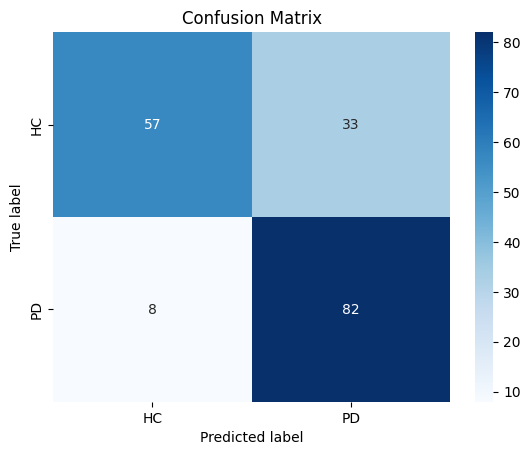

Accuracy for fold 7: 0.7722
Sensitivity for fold 7: 0.9111
Specificity for fold 7: 0.6333
Precision for fold 7: 0.7130
Recall for fold 7: 0.9111
F1 Score for fold 7: 0.8000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 7: 0.8744
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


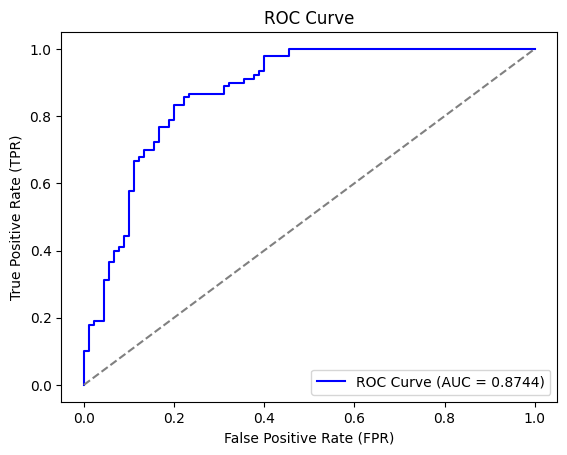

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5956 - loss: 0.8711 - val_accuracy: 0.3580 - val_loss: 1.2805
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7919 - loss: 0.5215 - val_accuracy: 0.6667 - val_loss: 0.6192
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8110 - loss: 0.4671 - val_accuracy: 0.8457 - val_loss: 0.3539
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8371 - loss: 0.4173 - val_accuracy: 0.9259 - val_loss: 0.2500
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8522 - loss: 0.3890 - val_accuracy: 0.9444 - val_loss: 0.1904
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8730 - loss: 0.3413 - val_accuracy: 0.9444 - val_loss: 0.1700
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8699 - loss: 0.3300 - val_accuracy: 0.9630 - val_loss: 0.1558
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8689 - loss: 0.3416 - val_accuracy: 0.9321 - val_loss: 0.

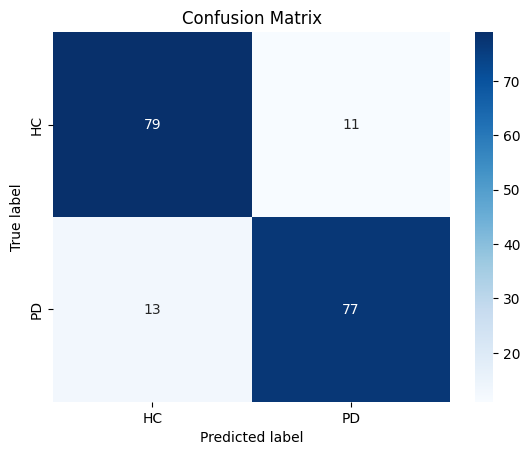

Accuracy for fold 8: 0.8667
Sensitivity for fold 8: 0.8556
Specificity for fold 8: 0.8778
Precision for fold 8: 0.8750
Recall for fold 8: 0.8556
F1 Score for fold 8: 0.8652
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 8: 0.9363
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


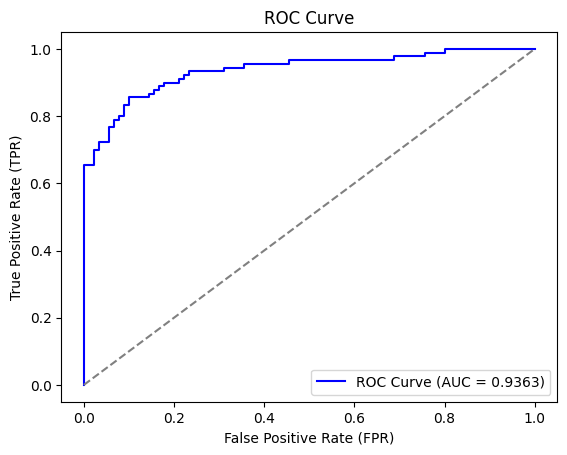

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6253 - loss: 0.8192 - val_accuracy: 0.3642 - val_loss: 1.9586
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8228 - loss: 0.4761 - val_accuracy: 0.7160 - val_loss: 0.5451
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8391 - loss: 0.4040 - val_accuracy: 0.8272 - val_loss: 0.4407
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8502 - loss: 0.4099 - val_accuracy: 0.9074 - val_loss: 0.2981
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8795 - loss: 0.3240 - val_accuracy: 0.8951 - val_loss: 0.3400
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8827 - loss: 0.3034 - val_accuracy: 0.9136 - val_loss: 0.2798
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8882 - loss: 0.2964 - val_accuracy: 0.9259 - val_loss: 0.2665
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8881 - loss: 0.2922 - val_accuracy: 0.9259 - val_loss: 0.

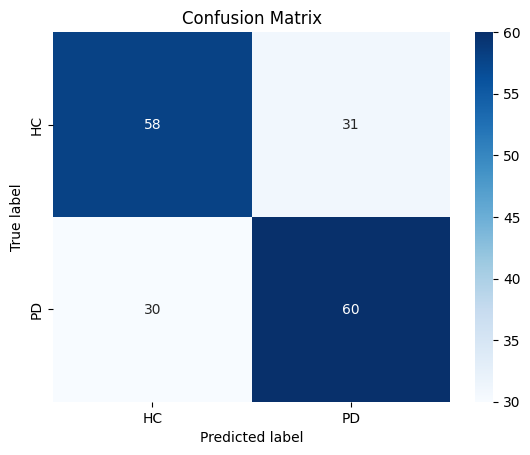

Accuracy for fold 9: 0.6592
Sensitivity for fold 9: 0.6667
Specificity for fold 9: 0.6517
Precision for fold 9: 0.6593
Recall for fold 9: 0.6667
F1 Score for fold 9: 0.6630
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 9: 0.7395
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


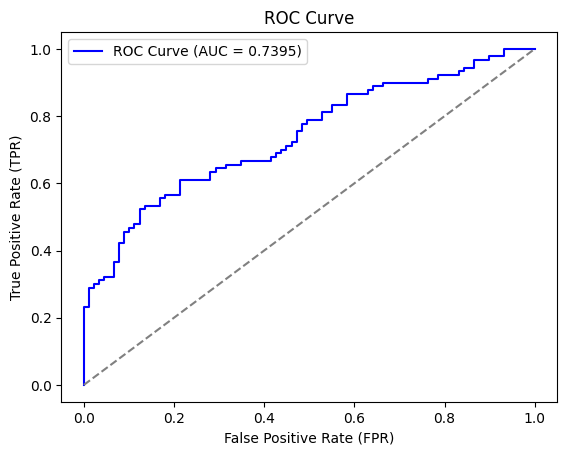

Epoch 1/15


/home/duyenkl/miniconda3/envs/speechbrain/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6050 - loss: 0.8660 - val_accuracy: 0.8457 - val_loss: 0.3615
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7533 - loss: 0.5726 - val_accuracy: 0.8827 - val_loss: 0.3111
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8084 - loss: 0.4744 - val_accuracy: 0.9444 - val_loss: 0.1944
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8298 - loss: 0.4313 - val_accuracy: 0.9383 - val_loss: 0.1501
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8520 - loss: 0.3828 - val_accuracy: 0.9383 - val_loss: 0.1422
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8571 - loss: 0.3704 - val_accuracy: 0.9259 - val_loss: 0.1492
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8723 - loss: 0.3419 - val_accuracy: 0.9383 - val_loss: 0.1450
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8592 - loss: 0.3246 - val_accuracy: 0.9383 - val_loss: 0.

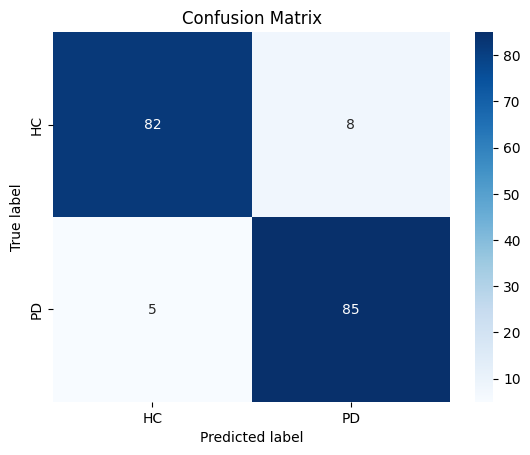

Accuracy for fold 10: 0.9278
Sensitivity for fold 10: 0.9444
Specificity for fold 10: 0.9111
Precision for fold 10: 0.9140
Recall for fold 10: 0.9444
F1 Score for fold 10: 0.9290
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
ROC AUC for fold 10: 0.9868
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


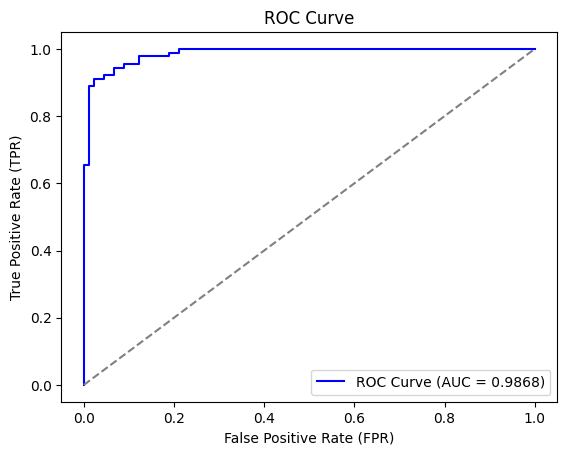

Average of evaluation metrics across folds:
Average accuracy: 0.7537 ± 0.0897
Average sensitivity: 0.7900 ± 0.1123
Average specificity: 0.7174 ± 0.1544
Average precision: 0.7514 ± 0.1065
Average recall: 0.7900 ± 0.1123
Average f1_score: 0.7622 ± 0.0845
Average roc_auc: 0.8265 ± 0.0913


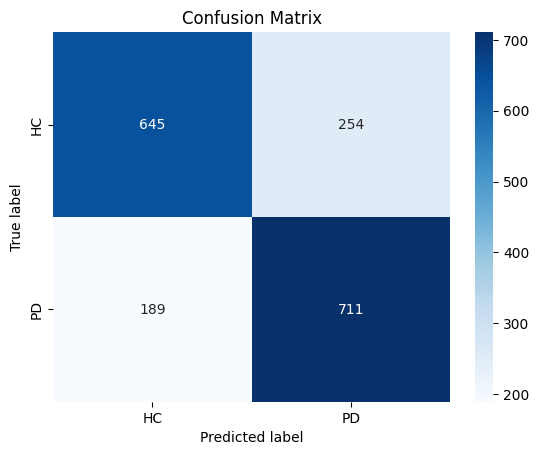

In [ ]:
# Define a simple CNN model
def create_cnn(input_shape, num_classes):
    model = Sequential()
    
    # Convolutional layer 1
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Convolitional layer 2
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    #Output layer
    model.add(Dense(num_classes, activation='softmax')) 
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

results = []
num_classes = 2
total_cm = np.zeros((2, 2), dtype=int)

# Iterate through all folds in dataset
for fold_idx in range(1,11): 

    # Define path for current fold
    fold_dir = os.path.join(folds_dir, f"TRAIN_TEST_{fold_idx}") 
    
    # File paths for data sets in current fold
    train_csv = os.path.join(fold_dir, "train.csv")
    test_csv = os.path.join(fold_dir, "test.csv")
    valid_csv = os.path.join(fold_dir, "valid.csv")
    
    # Prepare train and test and validation data
    X_train, y_train = prepare_data(train_csv, x_vector_dict)
    X_test, y_test = prepare_data(test_csv, x_vector_dict)
    X_valid, y_valid = prepare_data(valid_csv, x_vector_dict)
    
    # Convert labels to Keras categorical
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)
    y_valid = to_categorical(y_valid, num_classes=num_classes)
    
    # Reshape x-vectors for Conv1D input
    X_train = X_train[:, :, np.newaxis]
    X_test = X_test[:, :, np.newaxis]
    X_valid = X_valid[:, :, np.newaxis]

    # Create CNN model
    input_shape = (X_train.shape[1], 1)
    model = create_cnn(input_shape, num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train CNN classifier for current fold
    model.fit(X_train, 
              y_train,
              validation_data=(X_valid, y_valid),
              epochs=15,
              batch_size=32,
              callbacks = [early_stopping],
              verbose=1
    )

    # Evaluate CNN model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    if y_test.ndim > 1:
        y_test_label = np.argmax(y_test, axis=1)  # Convert one-hot encoded to class labels
    else:
        y_test_label = y_test

    if y_pred.ndim > 1:
        y_pred_label = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to class labels
    else:
        y_pred_label = y_pred
    
    # Evalution metrics
    cm = confusion_matrix(y_test_label, y_pred_label)
    total_cm += cm
    plt.figure()
    labels = ['HC', 'PD']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    
    accuracy = accuracy_score(y_test_label, y_pred_label)
    print(f'Accuracy for fold {fold_idx}: {accuracy:.4f}')
    
    sensitivity = recall_score(y_test_label, y_pred_label)
    specificity = recall_score(y_test_label, y_pred_label, pos_label=0)
    print(f'Sensitivity for fold {fold_idx}: {sensitivity:.4f}')
    print(f'Specificity for fold {fold_idx}: {specificity:.4f}')   
     
    precision = precision_score(y_test_label, y_pred_label)
    recall = recall_score(y_test_label, y_pred_label)
    f1 = f1_score(y_test_label, y_pred_label)
    print(f'Precision for fold {fold_idx}: {precision:.4f}')
    print(f'Recall for fold {fold_idx}: {recall:.4f}')
    print(f'F1 Score for fold {fold_idx}: {f1:.4f}')
    
    roc_auc = roc_auc_score(y_test_label, model.predict(X_test)[:, 1])
    print(f'ROC AUC for fold {fold_idx}: {roc_auc:.4f}')
    fpr, tpr, _ = roc_curve(y_test_label, model.predict(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    
    # Save the results for the current fold
    results.append({
        'fold': fold_idx,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    })
    
    results_df = pandas.DataFrame(results)
    results_csv = '/home/duyenkl/Parkinson2/evaluation_metrics/pretrained_xvector_cnn.csv'
    results_df.to_csv(results_csv, index=False)
    
# Average of evaluation metrics across folds with standard deviation
print(f'Average of evaluation metrics across folds:')
for metric in ['accuracy', 'sensitivity', 'specificity', 'precision', 'recall', 'f1_score', 'roc_auc']:
    metric_value = results_df[metric]
    average = np.mean(metric_value)
    standard_deviation = np.std(metric_value)
    print(f'Average {metric}: {average:.4f} ± {standard_deviation:.4f}')
           
           
plt.figure()
labels = ['HC', 'PD']
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# System with Custom-Trained X-Vector Model

### Generating x-vectors embedddings for the dataset (with speaking tasks DDK, read text, monologues and sentences) using a custom-trained x-vector model from scratch

In [10]:
# Load the custom-trained classifier from scratch
classifier = EncoderClassifier.from_hparams(source="/home/duyenkl/Parkinson2/results_fold9/results/best_model/", hparams_file='hparams_inference.yaml', savedir="/home/duyenkl/Parkinson2/results_fold9/results/best_model/")

# Load train, valid and test data 
test_df = pandas.read_csv("/home/duyenkl/Speech/pc-gita-splits/TRAIN_TEST_9/test.csv")
train_df = pandas.read_csv("/home/duyenkl/Speech/pc-gita-splits/TRAIN_TEST_9/train.csv")

# Combine data sets
fold_1_df = pd.concat([train_df, test_df]) 

# Embeddings and labels
embeddings = []
labels = []

# Function to extract the x-vector embeddings
def extract_x_vector(audio_file):
    signal, fs = torchaudio.load(audio_file)
    
    # Ensure the sample rate is 16 kHz
    if fs != 16000:
        transform = torchaudio.transforms.Resample(orig_freq=fs, new_freq=16000)
        signal = transform(signal)
    
    # Extract x-vector embeddings
    embedding = classifier.encode_batch(signal)
    return embedding.squeeze(0).cpu().numpy()

# Extract embeddings and labels from audio
for _, row in fold_1_df.iterrows():
    audio_file = row['audio_path']
    label = row['status']  # class 'hc' or 'pd'
    
    embedding = extract_x_vector(audio_file)
    embeddings.append(embedding)
    labels.append(label)
    
# Save embeddings and labels for the specific fold 
embeddings = np.array(embeddings)
labels = np.array(labels)
np.save('/home/duyenkl/Parkinson2/extracted_xvectors/fold9_xvectors.npy', embeddings)
np.save('/home/duyenkl/Parkinson2/extracted_xvectors/fold9_labels.npy', labels)

INFO:speechbrain.utils.fetching:Fetch hparams_inference.yaml: Using existing file/symlink in /home/duyenkl/Parkinson2/results_fold9/results/best_model/hparams_inference.yaml
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using existing file/symlink in /home/duyenkl/Parkinson2/results_fold9/results/best_model/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using existing file/symlink in /home/duyenkl/Parkinson2/results_fold9/results/best_model/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using existing file/symlink in /home/duyenkl/Parkinson2/results_fold9/results/best_model/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using existing file/symlink in /home/duyenkl/Parkinson2/results_fold9/results/best_model/classifier.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, classifier, label_encoder
/home/duyenkl/GitHub/speechbrain/speechbrain/utils/

### Training and testing a simple SVM classifier on data (with all speaking tasks from PC-GITA) with x-vectors from custom-trained x-vector model

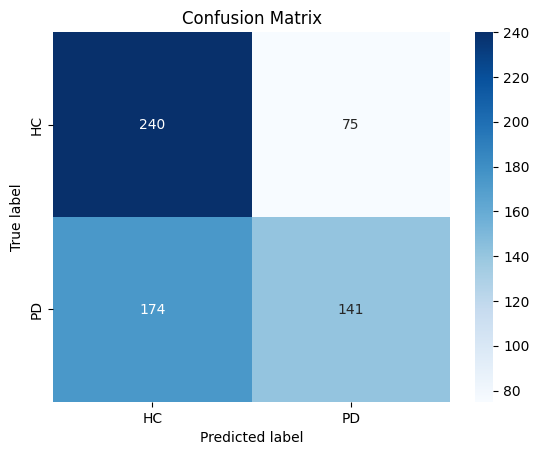

Accuracy for fold 0: 0.6048
Sensitivity for fold 0: 0.4476
Specificity for fold 0: 0.7619
Precision for fold 0: 0.6528
Recall for fold 0: 0.4476
F1 Score for fold 0: 0.5311
ROC AUC for fold for fold 0: 0.6451


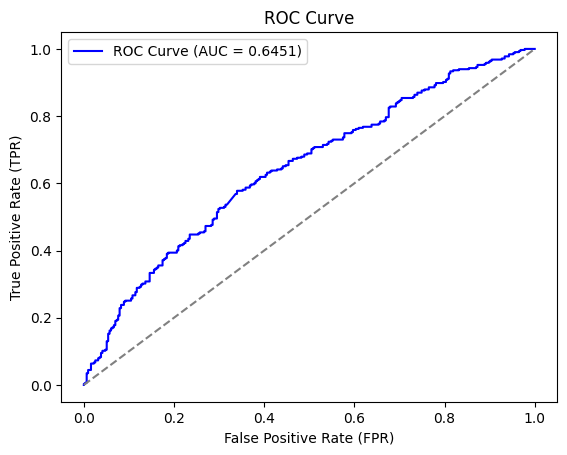

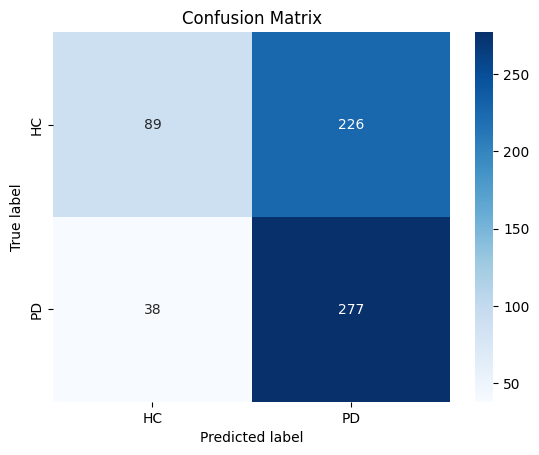

Accuracy for fold 1: 0.5810
Sensitivity for fold 1: 0.8794
Specificity for fold 1: 0.2825
Precision for fold 1: 0.5507
Recall for fold 1: 0.8794
F1 Score for fold 1: 0.6773
ROC AUC for fold for fold 1: 0.6456


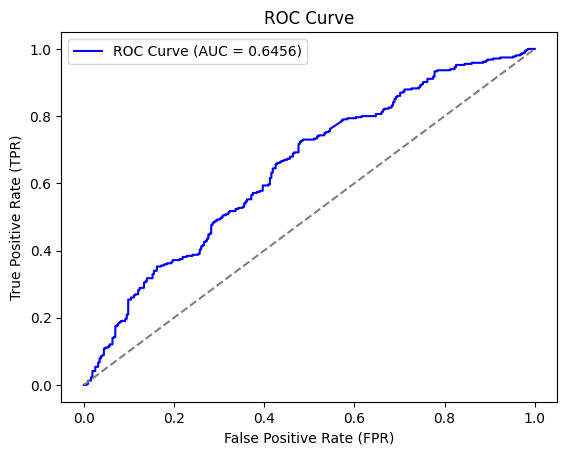

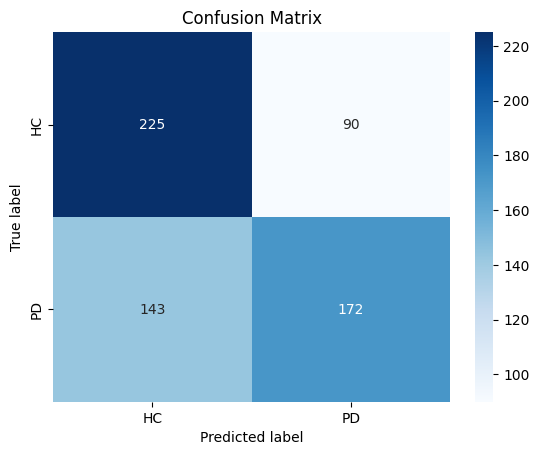

Accuracy for fold 2: 0.6302
Sensitivity for fold 2: 0.5460
Specificity for fold 2: 0.7143
Precision for fold 2: 0.6565
Recall for fold 2: 0.5460
F1 Score for fold 2: 0.5962
ROC AUC for fold for fold 2: 0.6942


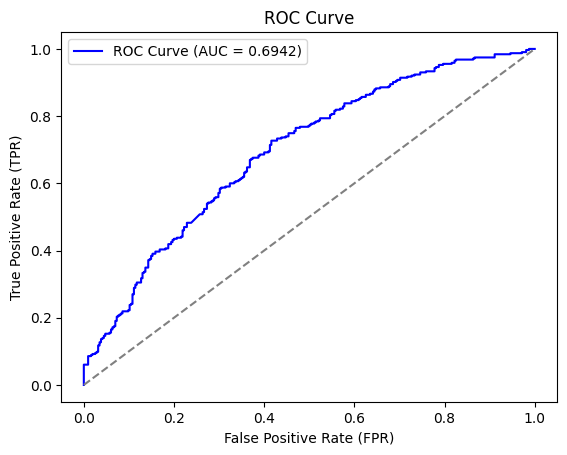

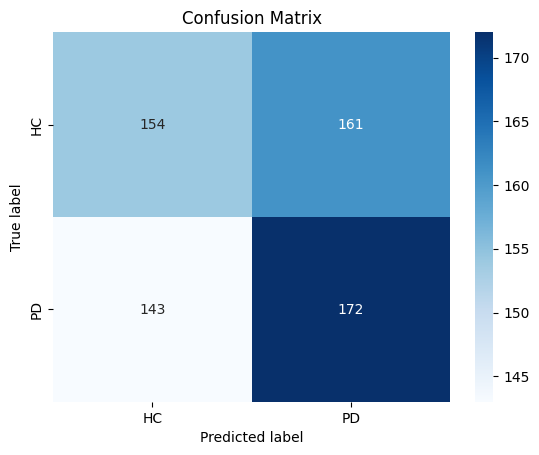

Accuracy for fold 3: 0.5175
Sensitivity for fold 3: 0.5460
Specificity for fold 3: 0.4889
Precision for fold 3: 0.5165
Recall for fold 3: 0.5460
F1 Score for fold 3: 0.5309
ROC AUC for fold for fold 3: 0.4834


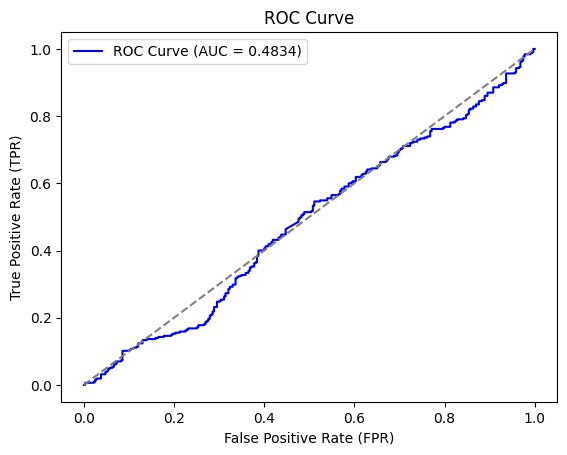

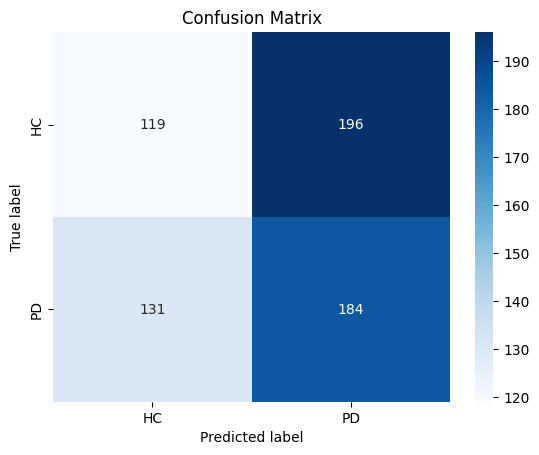

Accuracy for fold 4: 0.4810
Sensitivity for fold 4: 0.5841
Specificity for fold 4: 0.3778
Precision for fold 4: 0.4842
Recall for fold 4: 0.5841
F1 Score for fold 4: 0.5295
ROC AUC for fold for fold 4: 0.4744


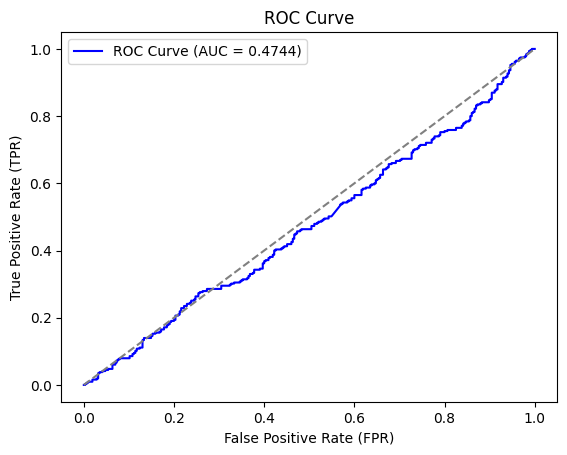

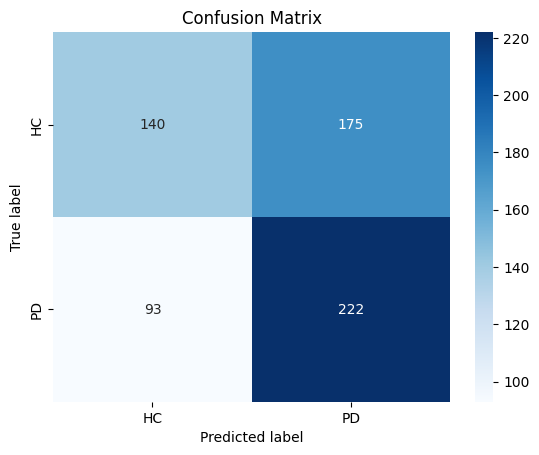

Accuracy for fold 5: 0.5746
Sensitivity for fold 5: 0.7048
Specificity for fold 5: 0.4444
Precision for fold 5: 0.5592
Recall for fold 5: 0.7048
F1 Score for fold 5: 0.6236
ROC AUC for fold for fold 5: 0.5936


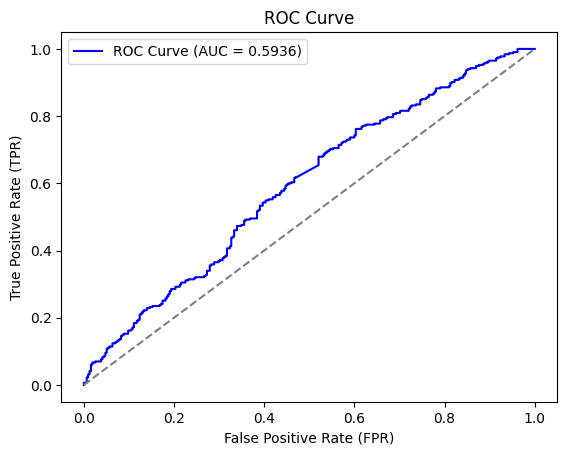

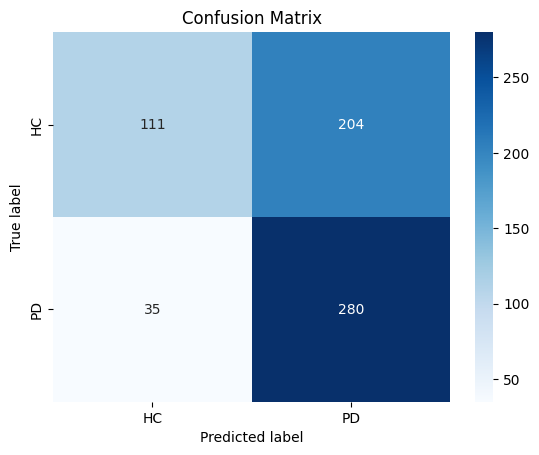

Accuracy for fold 6: 0.6206
Sensitivity for fold 6: 0.8889
Specificity for fold 6: 0.3524
Precision for fold 6: 0.5785
Recall for fold 6: 0.8889
F1 Score for fold 6: 0.7009
ROC AUC for fold for fold 6: 0.7264


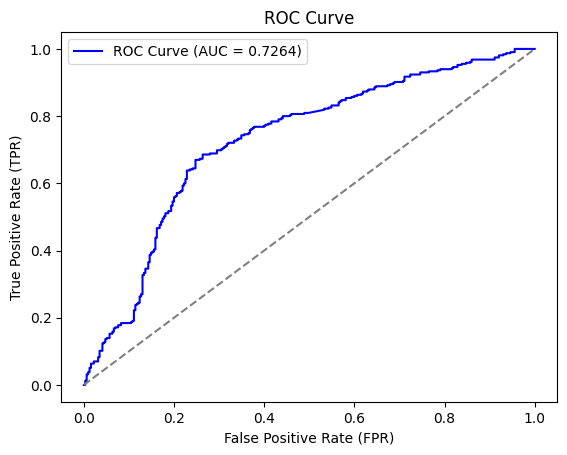

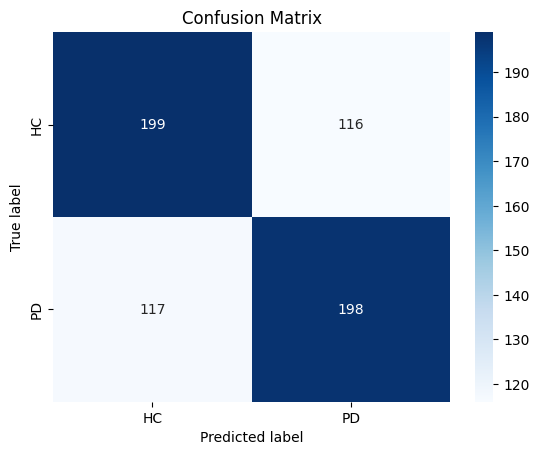

Accuracy for fold 7: 0.6302
Sensitivity for fold 7: 0.6286
Specificity for fold 7: 0.6317
Precision for fold 7: 0.6306
Recall for fold 7: 0.6286
F1 Score for fold 7: 0.6296
ROC AUC for fold for fold 7: 0.6912


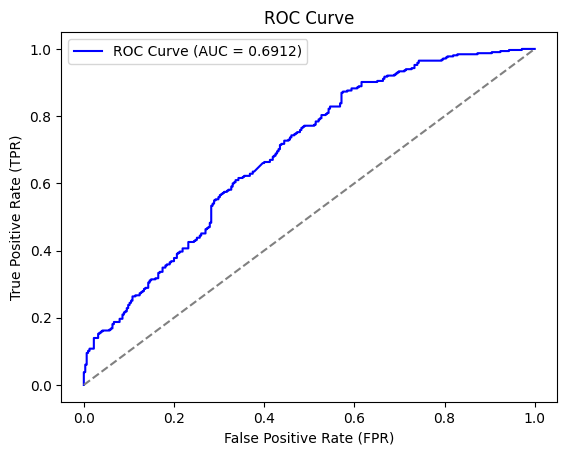

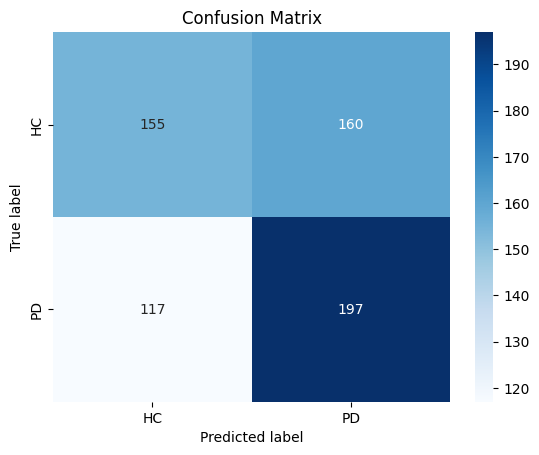

Accuracy for fold 8: 0.5596
Sensitivity for fold 8: 0.6274
Specificity for fold 8: 0.4921
Precision for fold 8: 0.5518
Recall for fold 8: 0.6274
F1 Score for fold 8: 0.5872
ROC AUC for fold for fold 8: 0.5766


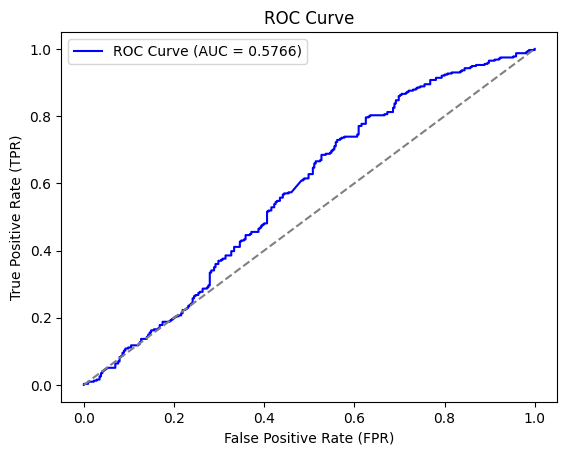

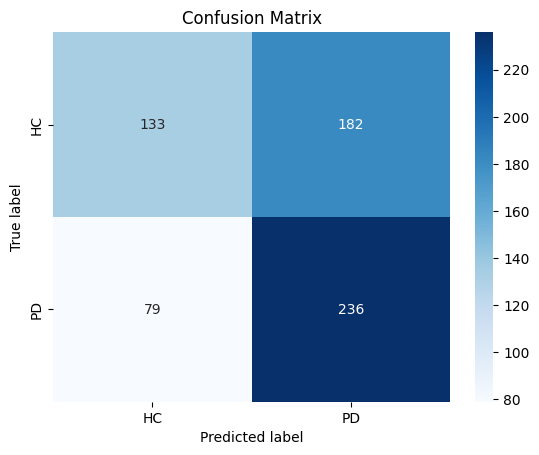

Accuracy for fold 9: 0.5857
Sensitivity for fold 9: 0.7492
Specificity for fold 9: 0.4222
Precision for fold 9: 0.5646
Recall for fold 9: 0.7492
F1 Score for fold 9: 0.6439
ROC AUC for fold for fold 9: 0.6385


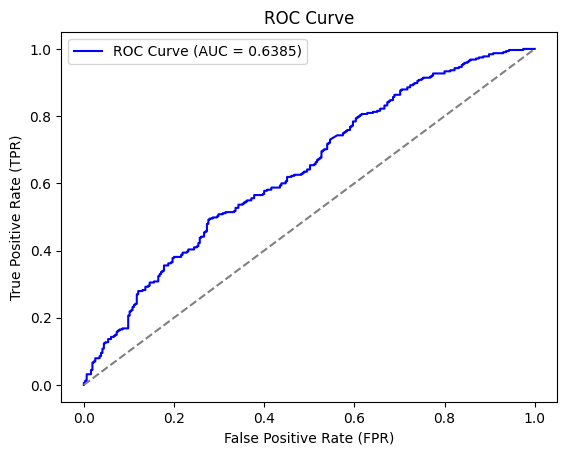

Average of evaluation metrics across folds:
Average accuracy: 0.5785 ± 0.0463
Average sensitivity: 0.6602 ± 0.1376
Average specificity: 0.4968 ± 0.1500
Average precision: 0.5745 ± 0.0538
Average recall: 0.6602 ± 0.1376
Average f1_score: 0.6050 ± 0.0583
Average roc_auc: 0.6169 ± 0.0812


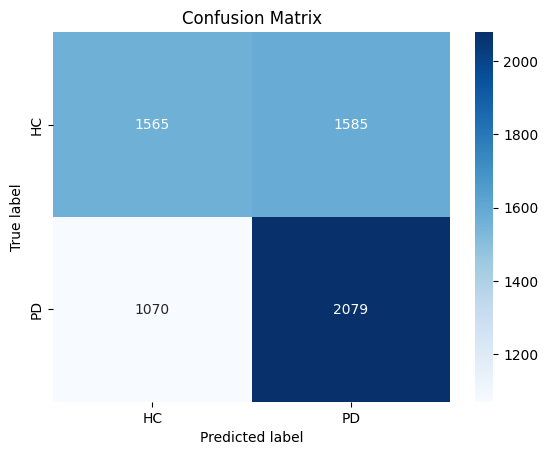

In [18]:
# For all folds
total_cm = np.zeros((2, 2), dtype=int)
results =[]

# Iterate through all folds
for fold_idx in range(0,10):

    # Load train and test split
    test_df = pandas.read_csv(f"/home/duyenkl/Speech/pc-gita-splits/TRAIN_TEST_{fold_idx}/test.csv")
    train_df = pandas.read_csv(f"/home/duyenkl/Speech/pc-gita-splits/TRAIN_TEST_{fold_idx}/train.csv")
    
    # Load embeddings and labels for the fold
    embeddings = np.load(f"/home/duyenkl/Parkinson2/extracted_xvectors/fold{fold_idx}_xvectors.npy")
    labels = np.load(f"/home/duyenkl/Parkinson2/extracted_xvectors/fold{fold_idx}_labels.npy")

    # Encode labels as 0 (HC) and 1 (PD)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    train_size = len(train_df) 
    test_size = len(test_df)

    X_train = embeddings[:train_size].squeeze(1)
    y_train = labels_encoded[:train_size]

    X_test = embeddings[train_size:train_size + test_size].squeeze(1)
    y_test = labels_encoded[train_size:train_size + test_size]
        
        
    # Train the SVM classifier
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)

    # Evaluate the SVM
    y_pred = clf.predict(X_test)

    # Evalution metrics
    cm = confusion_matrix(y_test, y_pred)
    total_cm += cm
    plt.figure()
    labels = ['HC', 'PD']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
        
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for fold {fold_idx}: {accuracy:.4f}')

    sensitivity = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    print(f'Sensitivity for fold {fold_idx}: {sensitivity:.4f}')
    print(f'Specificity for fold {fold_idx}: {specificity:.4f}')   
        
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Precision for fold {fold_idx}: {precision:.4f}')
    print(f'Recall for fold {fold_idx}: {recall:.4f}')
    print(f'F1 Score for fold {fold_idx}: {f1:.4f}')
        
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f'ROC AUC for fold for fold {fold_idx}: {roc_auc:.4f}')
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    
    # Save the results for the current fold
    results.append({
        'fold': fold_idx,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    })
    
    results_df = pandas.DataFrame(results)
    results_csv = '/home/duyenkl/Parkinson2/evaluation_metrics/customtrained_xvector_svm_all_speakingtasks.csv'
    results_df.to_csv(results_csv, index=False)
    
# Average of evaluation metrics across folds with standard deviation
print(f'Average of evaluation metrics across folds:')
for metric in ['accuracy', 'sensitivity', 'specificity', 'precision', 'recall', 'f1_score', 'roc_auc']:
    metric_value = results_df[metric]
    average = np.mean(metric_value)
    standard_deviation = np.std(metric_value)
    print(f'Average {metric}: {average:.4f} ± {standard_deviation:.4f}')
        
        
plt.figure()
labels = ['HC', 'PD']
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()    

### Training and testing a simple SVM classifier on data (with specific speking tasks DDK, read text, monologues and sentences) with x-vectors from custom-trained x-vector model

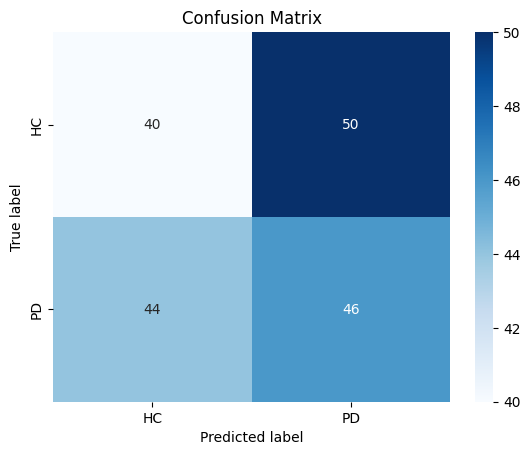

Accuracy for fold 1: 0.4778
Sensitivity for fold 1: 0.5111
Specificity for fold 1: 0.4444
Precision for fold 1: 0.4792
Recall for fold 1: 0.5111
F1 Score for fold 1: 0.4946
ROC AUC for fold for fold 1: 0.4893


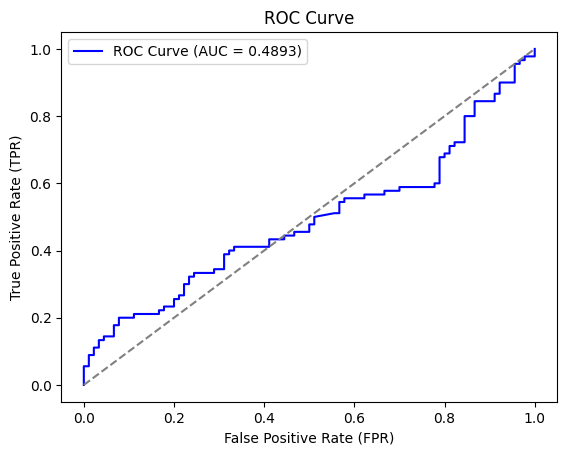

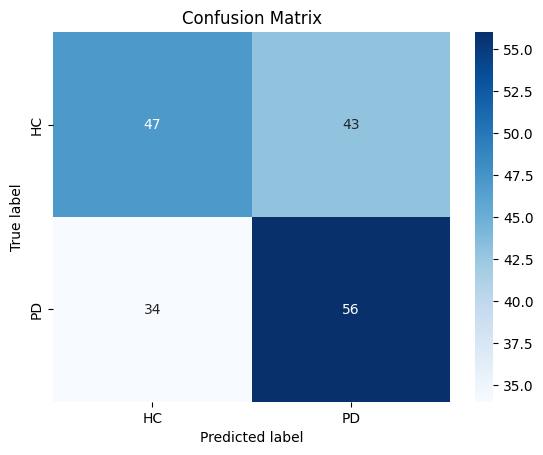

Accuracy for fold 2: 0.5722
Sensitivity for fold 2: 0.6222
Specificity for fold 2: 0.5222
Precision for fold 2: 0.5657
Recall for fold 2: 0.6222
F1 Score for fold 2: 0.5926
ROC AUC for fold for fold 2: 0.5973


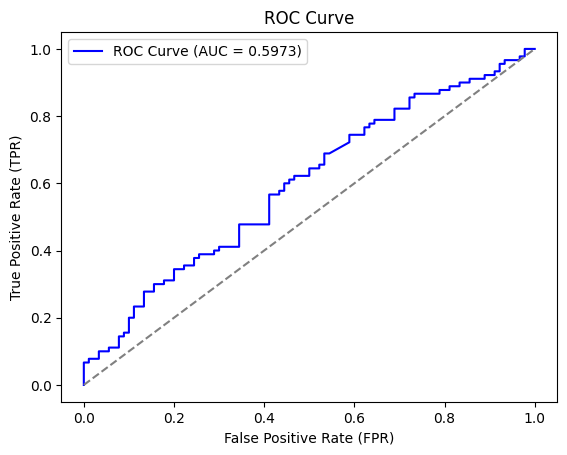

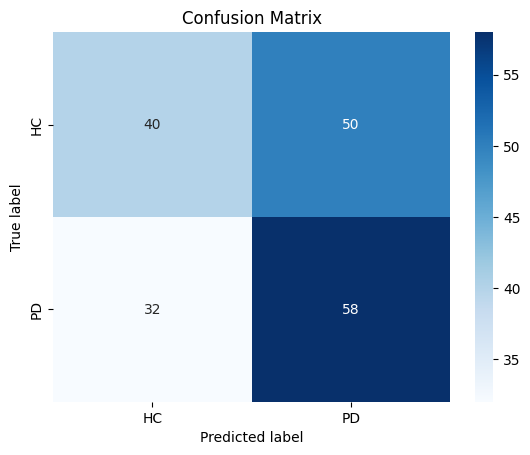

Accuracy for fold 3: 0.5444
Sensitivity for fold 3: 0.6444
Specificity for fold 3: 0.4444
Precision for fold 3: 0.5370
Recall for fold 3: 0.6444
F1 Score for fold 3: 0.5859
ROC AUC for fold for fold 3: 0.5606


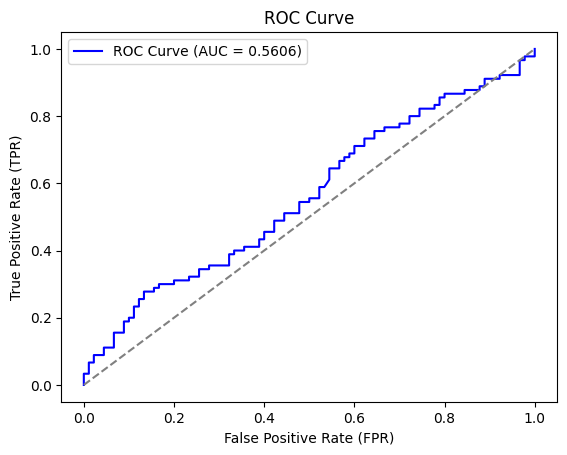

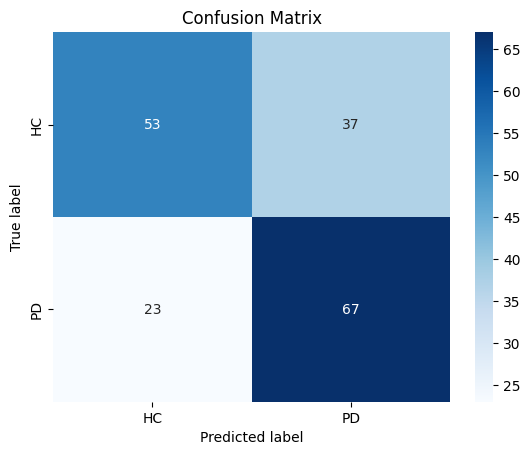

Accuracy for fold 4: 0.6667
Sensitivity for fold 4: 0.7444
Specificity for fold 4: 0.5889
Precision for fold 4: 0.6442
Recall for fold 4: 0.7444
F1 Score for fold 4: 0.6907
ROC AUC for fold for fold 4: 0.7311


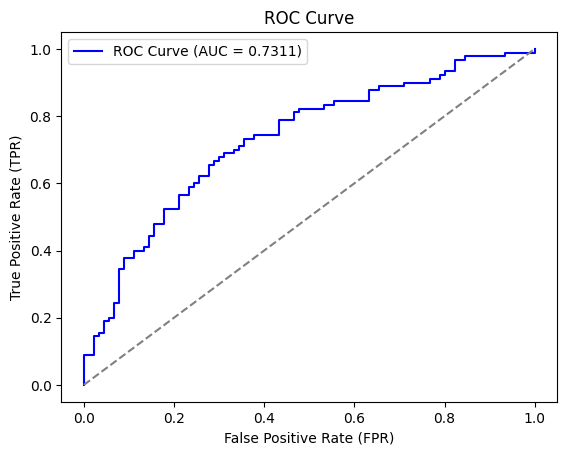

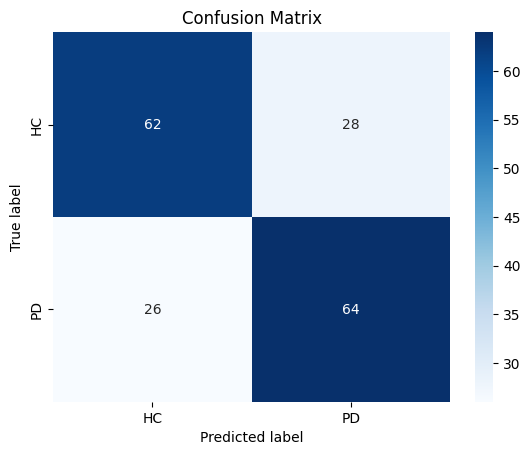

Accuracy for fold 5: 0.7000
Sensitivity for fold 5: 0.7111
Specificity for fold 5: 0.6889
Precision for fold 5: 0.6957
Recall for fold 5: 0.7111
F1 Score for fold 5: 0.7033
ROC AUC for fold for fold 5: 0.7469


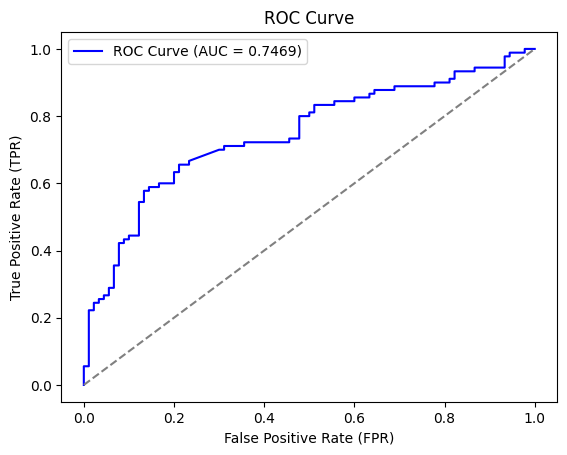

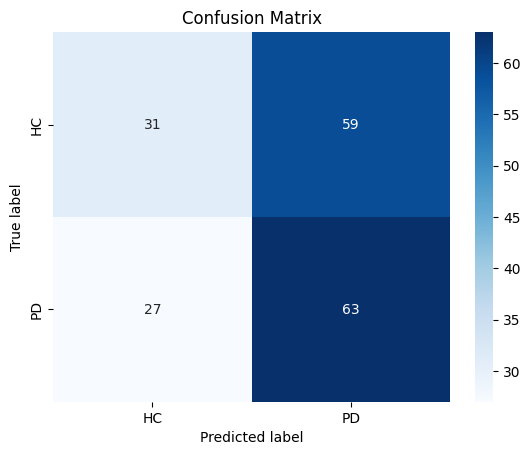

Accuracy for fold 6: 0.5222
Sensitivity for fold 6: 0.7000
Specificity for fold 6: 0.3444
Precision for fold 6: 0.5164
Recall for fold 6: 0.7000
F1 Score for fold 6: 0.5943
ROC AUC for fold for fold 6: 0.5295


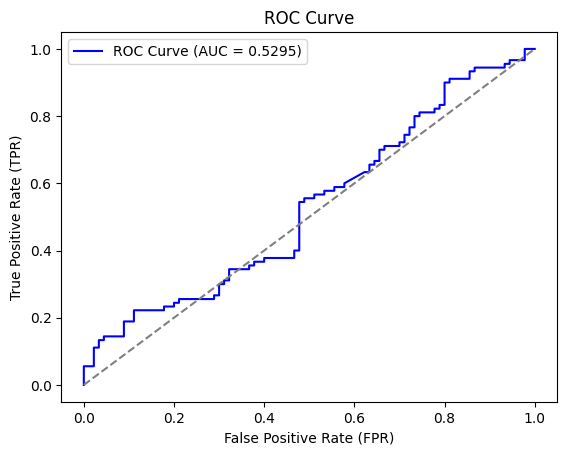

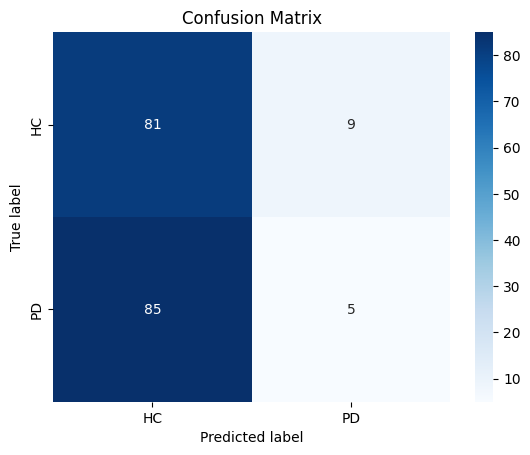

Accuracy for fold 7: 0.4778
Sensitivity for fold 7: 0.0556
Specificity for fold 7: 0.9000
Precision for fold 7: 0.3571
Recall for fold 7: 0.0556
F1 Score for fold 7: 0.0962
ROC AUC for fold for fold 7: 0.5067


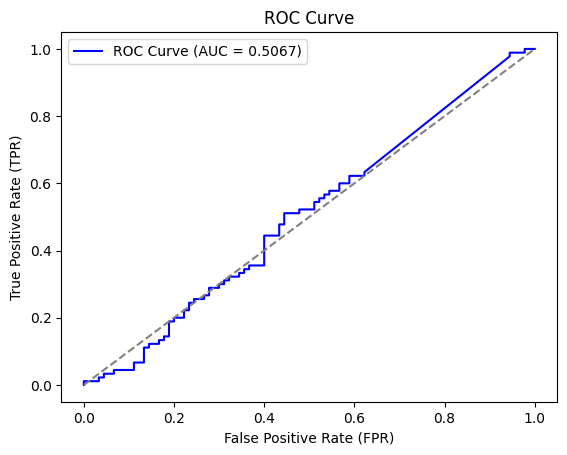

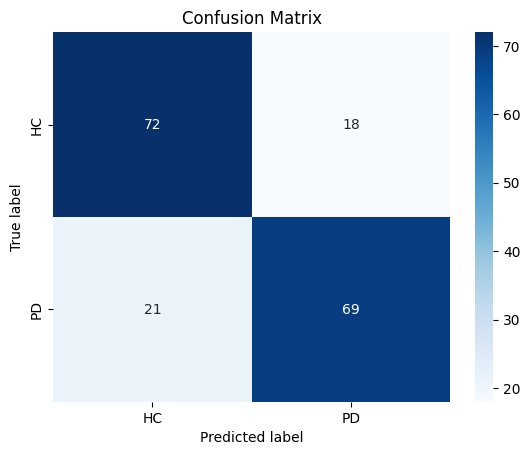

Accuracy for fold 8: 0.7833
Sensitivity for fold 8: 0.7667
Specificity for fold 8: 0.8000
Precision for fold 8: 0.7931
Recall for fold 8: 0.7667
F1 Score for fold 8: 0.7797
ROC AUC for fold for fold 8: 0.8668


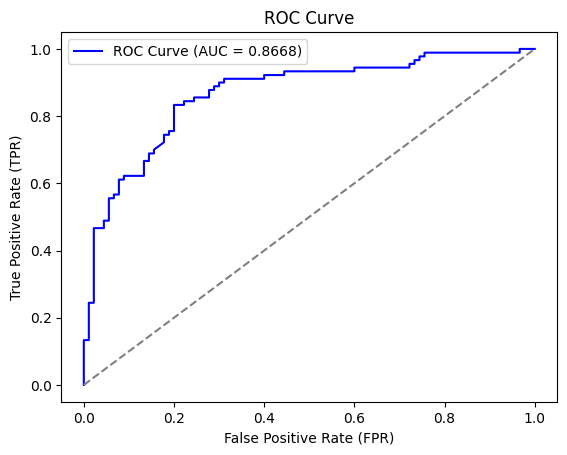

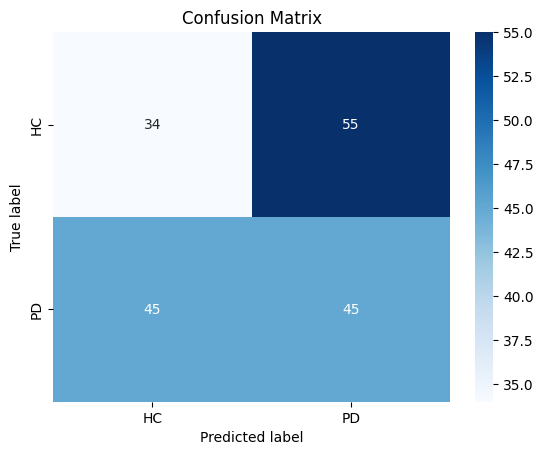

Accuracy for fold 9: 0.4413
Sensitivity for fold 9: 0.5000
Specificity for fold 9: 0.3820
Precision for fold 9: 0.4500
Recall for fold 9: 0.5000
F1 Score for fold 9: 0.4737
ROC AUC for fold for fold 9: 0.3851


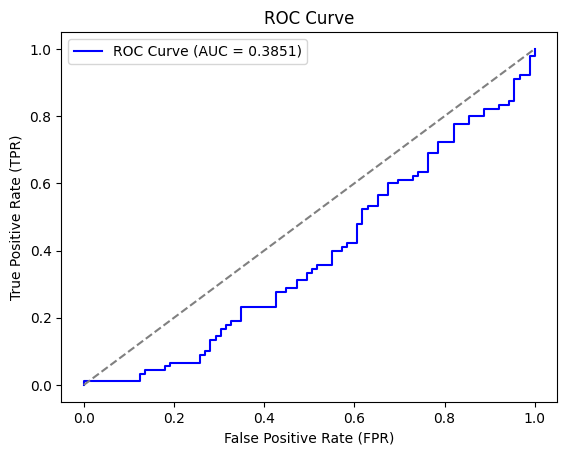

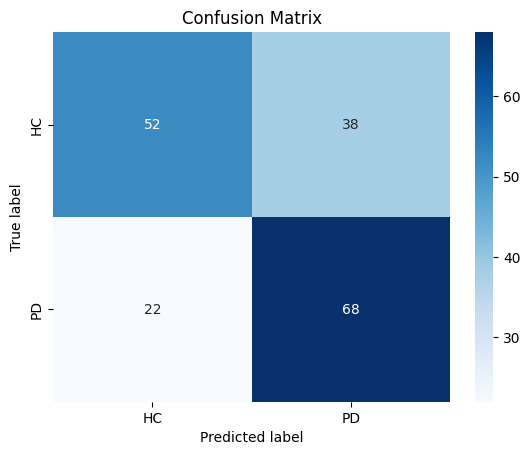

Accuracy for fold 10: 0.6667
Sensitivity for fold 10: 0.7556
Specificity for fold 10: 0.5778
Precision for fold 10: 0.6415
Recall for fold 10: 0.7556
F1 Score for fold 10: 0.6939
ROC AUC for fold for fold 10: 0.7710


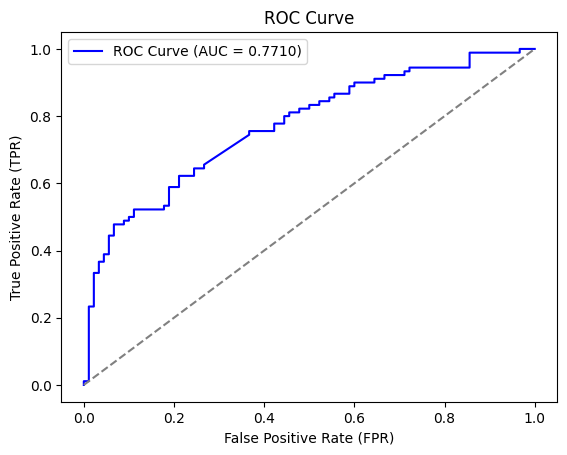

Average of evaluation metrics across folds:
Average accuracy: 0.5852 ± 0.1074
Average sensitivity: 0.6011 ± 0.2030
Average specificity: 0.5693 ± 0.1722
Average precision: 0.5680 ± 0.1217
Average recall: 0.6011 ± 0.2030
Average f1_score: 0.5705 ± 0.1823
Average roc_auc: 0.6184 ± 0.1447


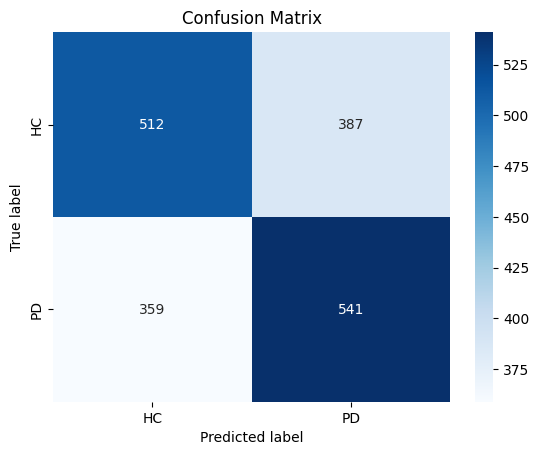

In [21]:
# For all folds
total_cm = np.zeros((2, 2), dtype=int)
results =[]

# Iterate through all folds
for fold_idx in range(1,11):

    # Load train and test split
    test_df = pandas.read_csv(f"/home/duyenkl/SSL4PR/pcgita_splits/TRAIN_TEST_{fold_idx}/test.csv")
    train_df = pandas.read_csv(f"/home/duyenkl/SSL4PR/pcgita_splits/TRAIN_TEST_{fold_idx}/train.csv")
    # Load embeddings and labels for the fold
    embeddings = np.load(f"/home/duyenkl/Parkinson2/extracted_xvectors/specific_speaking_tasks/fold{fold_idx}_xvectors.npy")
    labels = np.load(f"/home/duyenkl/Parkinson2/extracted_xvectors/specific_speaking_tasks/fold{fold_idx}_labels.npy")

    # Encode labels as 0 (HC) and 1 (PD)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    train_size = len(train_df) 
    test_size = len(test_df)

    X_train = embeddings[:train_size].squeeze(1)
    y_train = labels_encoded[:train_size]

    X_test = embeddings[train_size:train_size + test_size].squeeze(1)
    y_test = labels_encoded[train_size:train_size + test_size]
        
        
    # Train the SVM classifier
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)

    # Evaluate the SVM
    y_pred = clf.predict(X_test)

    # Evalution metrics
    cm = confusion_matrix(y_test, y_pred)
    total_cm += cm
    plt.figure()
    labels = ['HC', 'PD']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
        
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for fold {fold_idx}: {accuracy:.4f}')

    sensitivity = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    print(f'Sensitivity for fold {fold_idx}: {sensitivity:.4f}')
    print(f'Specificity for fold {fold_idx}: {specificity:.4f}')   
        
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Precision for fold {fold_idx}: {precision:.4f}')
    print(f'Recall for fold {fold_idx}: {recall:.4f}')
    print(f'F1 Score for fold {fold_idx}: {f1:.4f}')
        
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f'ROC AUC for fold for fold {fold_idx}: {roc_auc:.4f}')
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    
    # Save the results for the current fold
    results.append({
        'fold': fold_idx,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    })
    
    results_df = pandas.DataFrame(results)
    results_csv = '/home/duyenkl/Parkinson2/evaluation_metrics/customtrained_xvector_svm_specific_speakingtasks.csv'
    results_df.to_csv(results_csv, index=False)
    
# Average of evaluation metrics across folds with standard deviation
print(f'Average of evaluation metrics across folds:')
for metric in ['accuracy', 'sensitivity', 'specificity', 'precision', 'recall', 'f1_score', 'roc_auc']:
    metric_value = results_df[metric]
    average = np.mean(metric_value)
    standard_deviation = np.std(metric_value)
    print(f'Average {metric}: {average:.4f} ± {standard_deviation:.4f}')
        
        
plt.figure()
labels = ['HC', 'PD']
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
    

    